In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import optuna
import shap

In [2]:
# Construct the path to the CSV file
csv_file_path = "../Data/proj_4_feat_target_var_set.csv"

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Check the data
print(df.head())

   fips_code state_id  state_name  high_tourist_border_sales  year  \
0          1       AL     Alabama                          0  2010   
1          2       AK      Alaska                          1  2010   
2          4       AZ     Arizona                          0  2010   
3          5       AR    Arkansas                          0  2010   
4          6       CA  California                          0  2010   

   niaaa_pop_21_plus  census_total_pop  census_total_pop_21_plus  \
0            3439923           4785298                   3426273   
1             494781            713985                    494078   
2            4496526           6413737                   4502443   
3            2082760           2921606                   2074340   
4           26311028          37349363                  26293952   

   census_percent_pop_21_plus  census_percent_pop_18_24  ...  \
0                       0.716                     0.102  ...   
1                       0.692             

In [3]:
# Specify feature names and types
numerical_features = ['tpc_state_beer_tax_rates_dollar_gal','bea_personal_income_dollars','bea_disp_inc_dollars',	'bea_percapita_personal_income_dollars', 'bea_percapita_disp_inc_dollars',
                      'census_median_household_inc_dollars'] 
percentage_features = ['census_percent_pop_21_plus','census_percent_pop_18_24','census_percent_pop_25_34','census_percent_pop_35_44','census_percent_pop_45_54', 
                       'census_percent_pop_55_64', 'census_percent_pop_65_plus',	'census_percent_pop_male', 'census_percent_pop_female', 'census_percent_pop_married', 'census_percent_pop_widowed',	
                       'census_percent_pop_divorced',	'census_percent_pop_separated',	'census_percent_pop_never_married',	'ed_census_percent_pop_less_hs', 'ed_census_percent_pop_only_hs', 
                       'ed_census_percent_pop_some_college_or_assoc',	'ed_percent_pop_college_grad_only',	'ed_percent_pop_grad_prof_degree', 'census_percent_employed', 'census_percent_unemployed',
                       'census_percent_armed_forces_employment', 'census_percent_not_in_labor_force',	'brfss_drinking_culture_surrogate_metric_percent_binge', 'census_percent_pop_in_poverty_est']  # Replace with your percentage feature names
binary_features = ['high_tourist_border_sales']
target_column = 'niaaa_legal_adult_per_capita_beer_consumed_gallons'

X = df[numerical_features + percentage_features + binary_features]
y = df[target_column]

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('pct', MinMaxScaler(), percentage_features),
        ('cat', 'passthrough', binary_features)
    ],
    remainder='passthrough'  # This ensures any unspecified columns are passed through
)

In [5]:
# Define a function that creates a pipeline with given hyperparameters.
def create_pipeline(n_estimators, learning_rate, max_depth, subsample, colsample_bytree):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42))
    ])
    return pipeline

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 9)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    
    pipeline = create_pipeline(n_estimators, learning_rate, max_depth, subsample, colsample_bytree)
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Trial {trial.number}, MSE: {mse}, R2: {r2}")
    
    return mse

In [6]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250)

print("Best Parameters:", study.best_params)
print("Best Mean Squared Error:", study.best_value)

[I 2024-03-11 18:24:01,043] A new study created in memory with name: no-name-9256319d-064a-4f4c-8cf7-e036feb72bc1
[I 2024-03-11 18:24:02,255] Trial 0 finished with value: 5.081346853162957 and parameters: {'n_estimators': 669, 'learning_rate': 0.0032536223278851403, 'max_depth': 8, 'subsample': 0.5723080181054843, 'colsample_bytree': 0.6961988067260214}. Best is trial 0 with value: 5.081346853162957.
[I 2024-03-11 18:24:02,386] Trial 1 finished with value: 30.794464504836736 and parameters: {'n_estimators': 160, 'learning_rate': 0.0001447224465224581, 'max_depth': 4, 'subsample': 0.5347998500222642, 'colsample_bytree': 0.9671676011655619}. Best is trial 0 with value: 5.081346853162957.


Trial 0, MSE: 5.081346853162957, R2: 0.8363784992633192
Trial 1, MSE: 30.794464504836736, R2: 0.00840532200090549


[I 2024-03-11 18:24:03,152] Trial 2 finished with value: 2.419722462320333 and parameters: {'n_estimators': 916, 'learning_rate': 0.01598050767455478, 'max_depth': 5, 'subsample': 0.5263789479915414, 'colsample_bytree': 0.5815633074402906}. Best is trial 2 with value: 2.419722462320333.


Trial 2, MSE: 2.419722462320333, R2: 0.9220839214302672


[I 2024-03-11 18:24:03,543] Trial 3 finished with value: 22.385833576077665 and parameters: {'n_estimators': 532, 'learning_rate': 0.0006647906035170126, 'max_depth': 4, 'subsample': 0.8805122878357542, 'colsample_bytree': 0.7889395854211497}. Best is trial 2 with value: 2.419722462320333.


Trial 3, MSE: 22.385833576077665, R2: 0.2791667660554522


[I 2024-03-11 18:24:04,068] Trial 4 finished with value: 12.401860727688838 and parameters: {'n_estimators': 468, 'learning_rate': 0.001995559083479996, 'max_depth': 6, 'subsample': 0.5129319076255363, 'colsample_bytree': 0.6404890717122181}. Best is trial 2 with value: 2.419722462320333.


Trial 4, MSE: 12.401860727688838, R2: 0.6006548809143701


[I 2024-03-11 18:24:04,641] Trial 5 finished with value: 11.786383978075754 and parameters: {'n_estimators': 421, 'learning_rate': 0.0022089029172652954, 'max_depth': 6, 'subsample': 0.9634090361394259, 'colsample_bytree': 0.836258778830177}. Best is trial 2 with value: 2.419722462320333.


Trial 5, MSE: 11.786383978075754, R2: 0.620473490497682


[I 2024-03-11 18:24:05,114] Trial 6 finished with value: 2.4409343251091693 and parameters: {'n_estimators': 402, 'learning_rate': 0.051034173822688225, 'max_depth': 6, 'subsample': 0.5705783828485163, 'colsample_bytree': 0.7260529630588646}. Best is trial 2 with value: 2.419722462320333.


Trial 6, MSE: 2.4409343251091693, R2: 0.9214008905482542


[I 2024-03-11 18:24:06,134] Trial 7 finished with value: 25.542180281960057 and parameters: {'n_estimators': 464, 'learning_rate': 0.0003523776493037927, 'max_depth': 9, 'subsample': 0.880709397751797, 'colsample_bytree': 0.7917643542993171}. Best is trial 2 with value: 2.419722462320333.


Trial 7, MSE: 25.542180281960057, R2: 0.17753107776539068


[I 2024-03-11 18:24:06,743] Trial 8 finished with value: 27.258475319778945 and parameters: {'n_estimators': 748, 'learning_rate': 0.00017846897377248004, 'max_depth': 5, 'subsample': 0.6210911804000199, 'colsample_bytree': 0.5763135872299445}. Best is trial 2 with value: 2.419722462320333.


Trial 8, MSE: 27.258475319778945, R2: 0.12226565741329587


[I 2024-03-11 18:24:06,956] Trial 9 finished with value: 21.54095447139529 and parameters: {'n_estimators': 172, 'learning_rate': 0.0018835675609458339, 'max_depth': 6, 'subsample': 0.985081721150056, 'colsample_bytree': 0.5321805635602992}. Best is trial 2 with value: 2.419722462320333.


Trial 9, MSE: 21.54095447139529, R2: 0.3063722277261398


[I 2024-03-11 18:24:07,407] Trial 10 finished with value: 2.53153918298883 and parameters: {'n_estimators': 977, 'learning_rate': 0.029442334136755455, 'max_depth': 3, 'subsample': 0.7019899651679885, 'colsample_bytree': 0.5170956180425662}. Best is trial 2 with value: 2.419722462320333.


Trial 10, MSE: 2.53153918298883, R2: 0.9184833761079487


[I 2024-03-11 18:24:08,221] Trial 11 finished with value: 2.7005793877434177 and parameters: {'n_estimators': 980, 'learning_rate': 0.08705277526536713, 'max_depth': 7, 'subsample': 0.6612896299400292, 'colsample_bytree': 0.6486704075116835}. Best is trial 2 with value: 2.419722462320333.


Trial 11, MSE: 2.7005793877434177, R2: 0.9130402105878535


[I 2024-03-11 18:24:08,585] Trial 12 finished with value: 3.472887001314801 and parameters: {'n_estimators': 297, 'learning_rate': 0.015796283478092372, 'max_depth': 5, 'subsample': 0.7490870777843374, 'colsample_bytree': 0.9012954934144357}. Best is trial 2 with value: 2.419722462320333.


Trial 12, MSE: 3.472887001314801, R2: 0.888171581380962


[I 2024-03-11 18:24:09,664] Trial 13 finished with value: 2.3503886358053085 and parameters: {'n_estimators': 747, 'learning_rate': 0.012194205561446597, 'max_depth': 7, 'subsample': 0.5991020073514245, 'colsample_bytree': 0.7145210668463432}. Best is trial 13 with value: 2.3503886358053085.


Trial 13, MSE: 2.3503886358053085, R2: 0.9243164997355926


[I 2024-03-11 18:24:11,037] Trial 14 finished with value: 2.319367357958217 and parameters: {'n_estimators': 818, 'learning_rate': 0.011888817183401998, 'max_depth': 8, 'subsample': 0.6239117043683312, 'colsample_bytree': 0.6837085335886796}. Best is trial 14 with value: 2.319367357958217.


Trial 14, MSE: 2.319367357958217, R2: 0.9253153978983801


[I 2024-03-11 18:24:12,352] Trial 15 finished with value: 2.5076293903333626 and parameters: {'n_estimators': 780, 'learning_rate': 0.007872283811276222, 'max_depth': 8, 'subsample': 0.6290829000717487, 'colsample_bytree': 0.6767773427339857}. Best is trial 14 with value: 2.319367357958217.


Trial 15, MSE: 2.5076293903333626, R2: 0.9192532814636823


[I 2024-03-11 18:24:13,950] Trial 16 finished with value: 3.060983557726718 and parameters: {'n_estimators': 683, 'learning_rate': 0.006061790542534386, 'max_depth': 9, 'subsample': 0.7858231672910767, 'colsample_bytree': 0.7780681025524411}. Best is trial 14 with value: 2.319367357958217.


Trial 16, MSE: 3.060983557726718, R2: 0.9014350450936461


[I 2024-03-11 18:24:15,381] Trial 17 finished with value: 2.567963032298125 and parameters: {'n_estimators': 823, 'learning_rate': 0.011327407197994745, 'max_depth': 8, 'subsample': 0.7116746975904491, 'colsample_bytree': 0.8330785834738399}. Best is trial 14 with value: 2.319367357958217.


Trial 17, MSE: 2.567963032298125, R2: 0.9173105128772319


[I 2024-03-11 18:24:16,319] Trial 18 finished with value: 2.769358404827402 and parameters: {'n_estimators': 614, 'learning_rate': 0.029809484027895742, 'max_depth': 7, 'subsample': 0.7976688174814857, 'colsample_bytree': 0.6095835618915164}. Best is trial 14 with value: 2.319367357958217.


Trial 18, MSE: 2.769358404827402, R2: 0.9108254973789981


[I 2024-03-11 18:24:17,622] Trial 19 finished with value: 3.3622578000085532 and parameters: {'n_estimators': 864, 'learning_rate': 0.004628180669527484, 'max_depth': 7, 'subsample': 0.6116655391310701, 'colsample_bytree': 0.7266344103863983}. Best is trial 14 with value: 2.319367357958217.


Trial 19, MSE: 3.3622578000085532, R2: 0.8917338880815489


[I 2024-03-11 18:24:19,193] Trial 20 finished with value: 2.566995783144592 and parameters: {'n_estimators': 730, 'learning_rate': 0.028741030581278883, 'max_depth': 9, 'subsample': 0.6682230136476845, 'colsample_bytree': 0.8680399734356503}. Best is trial 14 with value: 2.319367357958217.


Trial 20, MSE: 2.566995783144592, R2: 0.9173416587058204


[I 2024-03-11 18:24:19,970] Trial 21 finished with value: 2.3097461889201565 and parameters: {'n_estimators': 901, 'learning_rate': 0.015206056693067021, 'max_depth': 5, 'subsample': 0.5014340091656962, 'colsample_bytree': 0.5924847508722133}. Best is trial 21 with value: 2.3097461889201565.


Trial 21, MSE: 2.3097461889201565, R2: 0.9256252035783189


[I 2024-03-11 18:24:21,213] Trial 22 finished with value: 2.235691751631858 and parameters: {'n_estimators': 878, 'learning_rate': 0.012041550073397711, 'max_depth': 7, 'subsample': 0.5735851526709878, 'colsample_bytree': 0.6708827976230909}. Best is trial 22 with value: 2.235691751631858.


Trial 22, MSE: 2.235691751631858, R2: 0.9280097875312485


[I 2024-03-11 18:24:22,694] Trial 23 finished with value: 11.281205004262914 and parameters: {'n_estimators': 892, 'learning_rate': 0.00112041445555348, 'max_depth': 8, 'subsample': 0.50063516338937, 'colsample_bytree': 0.645787566079347}. Best is trial 22 with value: 2.235691751631858.


Trial 23, MSE: 11.281205004262914, R2: 0.636740465420762


[I 2024-03-11 18:24:23,833] Trial 24 finished with value: 2.654111183367579 and parameters: {'n_estimators': 831, 'learning_rate': 0.007576330190304267, 'max_depth': 7, 'subsample': 0.5632742292971215, 'colsample_bytree': 0.5672364533656921}. Best is trial 22 with value: 2.235691751631858.


Trial 24, MSE: 2.654111183367579, R2: 0.9145365062661893


[I 2024-03-11 18:24:24,469] Trial 25 finished with value: 2.2431419348471926 and parameters: {'n_estimators': 942, 'learning_rate': 0.04723139282191586, 'max_depth': 4, 'subsample': 0.5498141248038507, 'colsample_bytree': 0.6128411341699656}. Best is trial 22 with value: 2.235691751631858.


Trial 25, MSE: 2.2431419348471926, R2: 0.927769888505718


[I 2024-03-11 18:24:25,130] Trial 26 finished with value: 2.176212678433952 and parameters: {'n_estimators': 931, 'learning_rate': 0.09440998466142617, 'max_depth': 4, 'subsample': 0.5510553021357457, 'colsample_bytree': 0.6098382768159342}. Best is trial 26 with value: 2.176212678433952.


Trial 26, MSE: 2.176212678433952, R2: 0.9299250386448407


[I 2024-03-11 18:24:25,623] Trial 27 finished with value: 2.0351881250247206 and parameters: {'n_estimators': 984, 'learning_rate': 0.09377356293390665, 'max_depth': 3, 'subsample': 0.5567538245706553, 'colsample_bytree': 0.6230382358711277}. Best is trial 27 with value: 2.0351881250247206.


Trial 27, MSE: 2.0351881250247206, R2: 0.9344660884366247


[I 2024-03-11 18:24:26,111] Trial 28 finished with value: 2.2890757855023756 and parameters: {'n_estimators': 1000, 'learning_rate': 0.09039633930063593, 'max_depth': 3, 'subsample': 0.6609593070885124, 'colsample_bytree': 0.5343306741841677}. Best is trial 27 with value: 2.0351881250247206.


Trial 28, MSE: 2.2890757855023756, R2: 0.9262907992413948


[I 2024-03-11 18:24:26,440] Trial 29 finished with value: 2.4316322442330045 and parameters: {'n_estimators': 618, 'learning_rate': 0.05192577427299564, 'max_depth': 3, 'subsample': 0.579167249998997, 'colsample_bytree': 0.6737036044370717}. Best is trial 27 with value: 2.0351881250247206.


Trial 29, MSE: 2.4316322442330045, R2: 0.9217004214554948


[I 2024-03-11 18:24:27,109] Trial 30 finished with value: 2.6293964528592775 and parameters: {'n_estimators': 947, 'learning_rate': 0.07169290550883281, 'max_depth': 4, 'subsample': 0.5833753429524291, 'colsample_bytree': 0.7590684898009049}. Best is trial 27 with value: 2.0351881250247206.


Trial 30, MSE: 2.6293964528592775, R2: 0.9153323309585253


[I 2024-03-11 18:24:27,725] Trial 31 finished with value: 2.1807465808565034 and parameters: {'n_estimators': 922, 'learning_rate': 0.04841298995696023, 'max_depth': 4, 'subsample': 0.5493781798514514, 'colsample_bytree': 0.624029014141518}. Best is trial 27 with value: 2.0351881250247206.


Trial 31, MSE: 2.1807465808565034, R2: 0.92977904508447


[I 2024-03-11 18:24:28,159] Trial 32 finished with value: 2.33503880445618 and parameters: {'n_estimators': 853, 'learning_rate': 0.0381192712347363, 'max_depth': 3, 'subsample': 0.5445222334684227, 'colsample_bytree': 0.6347369600664154}. Best is trial 27 with value: 2.0351881250247206.


Trial 32, MSE: 2.33503880445618, R2: 0.9248107707456175


[I 2024-03-11 18:24:28,771] Trial 33 finished with value: 2.353442953959774 and parameters: {'n_estimators': 916, 'learning_rate': 0.09782753998479167, 'max_depth': 4, 'subsample': 0.5378343367689287, 'colsample_bytree': 0.5525904593544558}. Best is trial 27 with value: 2.0351881250247206.


Trial 33, MSE: 2.353442953959774, R2: 0.924218149409468


[I 2024-03-11 18:24:29,283] Trial 34 finished with value: 2.3799811916853213 and parameters: {'n_estimators': 994, 'learning_rate': 0.022557249069837533, 'max_depth': 3, 'subsample': 0.5338966001501485, 'colsample_bytree': 0.6167382056673574}. Best is trial 27 with value: 2.0351881250247206.


Trial 34, MSE: 2.3799811916853213, R2: 0.9233636070196175


[I 2024-03-11 18:24:29,892] Trial 35 finished with value: 2.5846454694799044 and parameters: {'n_estimators': 882, 'learning_rate': 0.06392650590967668, 'max_depth': 4, 'subsample': 0.5908241110743826, 'colsample_bytree': 0.6879687570658733}. Best is trial 27 with value: 2.0351881250247206.


Trial 35, MSE: 2.5846454694799044, R2: 0.9167733314002522


[I 2024-03-11 18:24:30,355] Trial 36 finished with value: 2.4947855380589528 and parameters: {'n_estimators': 695, 'learning_rate': 0.019415748334692482, 'max_depth': 4, 'subsample': 0.5275835877895315, 'colsample_bytree': 0.5890157092754374}. Best is trial 27 with value: 2.0351881250247206.


Trial 36, MSE: 2.4947855380589528, R2: 0.9196668588960261


[I 2024-03-11 18:24:31,153] Trial 37 finished with value: 2.416538512995575 and parameters: {'n_estimators': 786, 'learning_rate': 0.039573740263965713, 'max_depth': 5, 'subsample': 0.6523220308003035, 'colsample_bytree': 0.9837456045642854}. Best is trial 27 with value: 2.0351881250247206.


Trial 37, MSE: 2.416538512995575, R2: 0.9221864459344667


[I 2024-03-11 18:24:31,997] Trial 38 finished with value: 2.2717041098472004 and parameters: {'n_estimators': 934, 'learning_rate': 0.06262773970757814, 'max_depth': 5, 'subsample': 0.5670484126238742, 'colsample_bytree': 0.6654716581028762}. Best is trial 27 with value: 2.0351881250247206.


Trial 38, MSE: 2.2717041098472004, R2: 0.926850174486413


[I 2024-03-11 18:24:32,431] Trial 39 finished with value: 2.779743355773389 and parameters: {'n_estimators': 607, 'learning_rate': 0.024176488688479568, 'max_depth': 4, 'subsample': 0.6900940108039759, 'colsample_bytree': 0.7090065631108958}. Best is trial 27 with value: 2.0351881250247206.


Trial 39, MSE: 2.779743355773389, R2: 0.9104910976011515


[I 2024-03-11 18:24:32,834] Trial 40 finished with value: 8.280203467189088 and parameters: {'n_estimators': 790, 'learning_rate': 0.0030984136073729093, 'max_depth': 3, 'subsample': 0.9315671865961264, 'colsample_bytree': 0.5540467420124426}. Best is trial 27 with value: 2.0351881250247206.


Trial 40, MSE: 8.280203467189088, R2: 0.7333739740944432


[I 2024-03-11 18:24:33,487] Trial 41 finished with value: 2.1147093212003023 and parameters: {'n_estimators': 940, 'learning_rate': 0.052440417203785075, 'max_depth': 4, 'subsample': 0.5437661917803013, 'colsample_bytree': 0.6175086837470414}. Best is trial 27 with value: 2.0351881250247206.


Trial 41, MSE: 2.1147093212003023, R2: 0.9319054725537461


[I 2024-03-11 18:24:34,134] Trial 42 finished with value: 2.2344665348982162 and parameters: {'n_estimators': 956, 'learning_rate': 0.03732177858010916, 'max_depth': 4, 'subsample': 0.5234773313634276, 'colsample_bytree': 0.6311987660967822}. Best is trial 27 with value: 2.0351881250247206.


Trial 42, MSE: 2.2344665348982162, R2: 0.9280492400241562


[I 2024-03-11 18:24:34,819] Trial 43 finished with value: 2.328671563635668 and parameters: {'n_estimators': 956, 'learning_rate': 0.038611236720152285, 'max_depth': 4, 'subsample': 0.5184412498260931, 'colsample_bytree': 0.6284449018242756}. Best is trial 27 with value: 2.0351881250247206.


Trial 43, MSE: 2.328671563635668, R2: 0.9250157985716465


[I 2024-03-11 18:24:35,261] Trial 44 finished with value: 1.9526705930774406 and parameters: {'n_estimators': 919, 'learning_rate': 0.06692442475735966, 'max_depth': 3, 'subsample': 0.5521071328003055, 'colsample_bytree': 0.50469445283492}. Best is trial 44 with value: 1.9526705930774406.


Trial 44, MSE: 1.9526705930774406, R2: 0.9371231875885744


[I 2024-03-11 18:24:35,703] Trial 45 finished with value: 2.4185727319102397 and parameters: {'n_estimators': 909, 'learning_rate': 0.06413980206953518, 'max_depth': 3, 'subsample': 0.5551981231329107, 'colsample_bytree': 0.5397484112289428}. Best is trial 44 with value: 1.9526705930774406.
[I 2024-03-11 18:24:35,862] Trial 46 finished with value: 2.472620409718346 and parameters: {'n_estimators': 248, 'learning_rate': 0.0988187078032062, 'max_depth': 3, 'subsample': 0.6042519313091356, 'colsample_bytree': 0.5077215124318836}. Best is trial 44 with value: 1.9526705930774406.


Trial 45, MSE: 2.4185727319102397, R2: 0.9221209432318836
Trial 46, MSE: 2.472620409718346, R2: 0.9203805853287835


[I 2024-03-11 18:24:36,627] Trial 47 finished with value: 2.484811075259433 and parameters: {'n_estimators': 842, 'learning_rate': 0.07128548412325968, 'max_depth': 5, 'subsample': 0.6315961945955002, 'colsample_bytree': 0.5037563088183604}. Best is trial 44 with value: 1.9526705930774406.


Trial 47, MSE: 2.484811075259433, R2: 0.9199880407833212


[I 2024-03-11 18:24:36,902] Trial 48 finished with value: 29.960468231874597 and parameters: {'n_estimators': 512, 'learning_rate': 0.0001196578109900439, 'max_depth': 3, 'subsample': 0.5919918187935467, 'colsample_bytree': 0.5929799125505548}. Best is trial 44 with value: 1.9526705930774406.


Trial 48, MSE: 29.960468231874597, R2: 0.035260351923911526


[I 2024-03-11 18:24:37,168] Trial 49 finished with value: 2.2617212016997588 and parameters: {'n_estimators': 348, 'learning_rate': 0.050396094401565186, 'max_depth': 4, 'subsample': 0.5533487330642837, 'colsample_bytree': 0.5669280623105282}. Best is trial 44 with value: 1.9526705930774406.


Trial 49, MSE: 2.2617212016997588, R2: 0.9271716283174547


[I 2024-03-11 18:24:37,657] Trial 50 finished with value: 2.5544500354887276 and parameters: {'n_estimators': 972, 'learning_rate': 0.0758244485915072, 'max_depth': 3, 'subsample': 0.6356751662605179, 'colsample_bytree': 0.6488986040328094}. Best is trial 44 with value: 1.9526705930774406.


Trial 50, MSE: 2.5544500354887276, R2: 0.9177456370443663


[I 2024-03-11 18:24:38,328] Trial 51 finished with value: 2.091869571566378 and parameters: {'n_estimators': 956, 'learning_rate': 0.036128767837091944, 'max_depth': 4, 'subsample': 0.5224511249928463, 'colsample_bytree': 0.606181613107705}. Best is trial 44 with value: 1.9526705930774406.


Trial 51, MSE: 2.091869571566378, R2: 0.9326409220752103


[I 2024-03-11 18:24:38,942] Trial 52 finished with value: 2.4011650693069564 and parameters: {'n_estimators': 921, 'learning_rate': 0.05217072860617115, 'max_depth': 4, 'subsample': 0.5200599498516829, 'colsample_bytree': 0.6064421993296943}. Best is trial 44 with value: 1.9526705930774406.


Trial 52, MSE: 2.4011650693069564, R2: 0.9226814772717306


[I 2024-03-11 18:24:39,515] Trial 53 finished with value: 24.260887592191963 and parameters: {'n_estimators': 869, 'learning_rate': 0.0003158918735934255, 'max_depth': 4, 'subsample': 0.5417451905194355, 'colsample_bytree': 0.5763830024465401}. Best is trial 44 with value: 1.9526705930774406.


Trial 53, MSE: 24.260887592191963, R2: 0.21878923998911204


[I 2024-03-11 18:24:40,472] Trial 54 finished with value: 2.1454847824285928 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0330060751349857, 'max_depth': 5, 'subsample': 0.5030855525383127, 'colsample_bytree': 0.9301679127202962}. Best is trial 44 with value: 1.9526705930774406.


Trial 54, MSE: 2.1454847824285928, R2: 0.9309144897892253


[I 2024-03-11 18:24:41,410] Trial 55 finished with value: 2.206231914101932 and parameters: {'n_estimators': 996, 'learning_rate': 0.028926329177492664, 'max_depth': 5, 'subsample': 0.504702054182827, 'colsample_bytree': 0.953828284921003}. Best is trial 44 with value: 1.9526705930774406.


Trial 55, MSE: 2.206231914101932, R2: 0.9289584066606639


[I 2024-03-11 18:24:42,603] Trial 56 finished with value: 2.663466440844884 and parameters: {'n_estimators': 965, 'learning_rate': 0.017149244655741098, 'max_depth': 6, 'subsample': 0.8268301170054789, 'colsample_bytree': 0.8335992927090735}. Best is trial 44 with value: 1.9526705930774406.


Trial 56, MSE: 2.663466440844884, R2: 0.9142352630500798


[I 2024-03-11 18:24:43,553] Trial 57 finished with value: 2.125610619815857 and parameters: {'n_estimators': 809, 'learning_rate': 0.031041693376967758, 'max_depth': 6, 'subsample': 0.5156694241078444, 'colsample_bytree': 0.7403750957004801}. Best is trial 44 with value: 1.9526705930774406.


Trial 57, MSE: 2.125610619815857, R2: 0.9315544461642868


[I 2024-03-11 18:24:44,596] Trial 58 finished with value: 2.177479734702815 and parameters: {'n_estimators': 810, 'learning_rate': 0.022348187801015062, 'max_depth': 6, 'subsample': 0.5156297696569688, 'colsample_bytree': 0.90944491622618}. Best is trial 44 with value: 1.9526705930774406.


Trial 58, MSE: 2.177479734702815, R2: 0.9298842389013434


[I 2024-03-11 18:24:45,530] Trial 59 finished with value: 2.417022883797972 and parameters: {'n_estimators': 753, 'learning_rate': 0.03071537943315898, 'max_depth': 6, 'subsample': 0.610951924588789, 'colsample_bytree': 0.7857829542782379}. Best is trial 44 with value: 1.9526705930774406.


Trial 59, MSE: 2.417022883797972, R2: 0.9221708489913941


[I 2024-03-11 18:24:46,579] Trial 60 finished with value: 2.654465654122939 and parameters: {'n_estimators': 890, 'learning_rate': 0.008471875780422421, 'max_depth': 6, 'subsample': 0.5683614176518685, 'colsample_bytree': 0.8044998846866972}. Best is trial 44 with value: 1.9526705930774406.


Trial 60, MSE: 2.654465654122939, R2: 0.9145250921591356


[I 2024-03-11 18:24:47,557] Trial 61 finished with value: 2.3949257008798575 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07502294132932122, 'max_depth': 5, 'subsample': 0.503586517248415, 'colsample_bytree': 0.7403800226951783}. Best is trial 44 with value: 1.9526705930774406.


Trial 61, MSE: 2.3949257008798575, R2: 0.9228823875530383


[I 2024-03-11 18:24:48,508] Trial 62 finished with value: 2.5429041016182703 and parameters: {'n_estimators': 949, 'learning_rate': 0.0586023632314989, 'max_depth': 5, 'subsample': 0.533897224145331, 'colsample_bytree': 0.8595476851212815}. Best is trial 44 with value: 1.9526705930774406.


Trial 62, MSE: 2.5429041016182703, R2: 0.9181174209595137


[I 2024-03-11 18:24:48,943] Trial 63 finished with value: 2.328368490351395 and parameters: {'n_estimators': 861, 'learning_rate': 0.04300782411090981, 'max_depth': 3, 'subsample': 0.7420320014140399, 'colsample_bytree': 0.6585890947899466}. Best is trial 44 with value: 1.9526705930774406.


Trial 63, MSE: 2.328368490351395, R2: 0.9250255576585656


[I 2024-03-11 18:24:49,807] Trial 64 finished with value: 2.066134424752768 and parameters: {'n_estimators': 927, 'learning_rate': 0.08175243412752314, 'max_depth': 5, 'subsample': 0.5655693195072599, 'colsample_bytree': 0.5258883448238684}. Best is trial 44 with value: 1.9526705930774406.


Trial 64, MSE: 2.066134424752768, R2: 0.9334696046007303


[I 2024-03-11 18:24:50,620] Trial 65 finished with value: 2.1519627179977783 and parameters: {'n_estimators': 900, 'learning_rate': 0.03530906029286193, 'max_depth': 5, 'subsample': 0.5743905302180272, 'colsample_bytree': 0.5192595926076605}. Best is trial 44 with value: 1.9526705930774406.


Trial 65, MSE: 2.1519627179977783, R2: 0.9307058975458429


[I 2024-03-11 18:24:51,634] Trial 66 finished with value: 2.412716654711561 and parameters: {'n_estimators': 970, 'learning_rate': 0.07722278009311405, 'max_depth': 6, 'subsample': 0.5233385056858301, 'colsample_bytree': 0.7567920703024331}. Best is trial 44 with value: 1.9526705930774406.


Trial 66, MSE: 2.412716654711561, R2: 0.9223095113748123


[I 2024-03-11 18:24:52,561] Trial 67 finished with value: 12.308021958304073 and parameters: {'n_estimators': 846, 'learning_rate': 0.001103048095012386, 'max_depth': 6, 'subsample': 0.5985667649518955, 'colsample_bytree': 0.5232186685595486}. Best is trial 44 with value: 1.9526705930774406.


Trial 67, MSE: 12.308021958304073, R2: 0.6036765286620458


[I 2024-03-11 18:24:52,966] Trial 68 finished with value: 2.4598322347004067 and parameters: {'n_estimators': 808, 'learning_rate': 0.025203935486530063, 'max_depth': 3, 'subsample': 0.5656132535058503, 'colsample_bytree': 0.5604645168113871}. Best is trial 44 with value: 1.9526705930774406.


Trial 68, MSE: 2.4598322347004067, R2: 0.9207923699301075


[I 2024-03-11 18:24:53,826] Trial 69 finished with value: 2.533656630493724 and parameters: {'n_estimators': 931, 'learning_rate': 0.05652058097238363, 'max_depth': 5, 'subsample': 0.5015093857955238, 'colsample_bytree': 0.7016115247906197}. Best is trial 44 with value: 1.9526705930774406.


Trial 69, MSE: 2.533656630493724, R2: 0.9184151934098386


[I 2024-03-11 18:24:54,672] Trial 70 finished with value: 2.3221829141678367 and parameters: {'n_estimators': 968, 'learning_rate': 0.018706429456291484, 'max_depth': 5, 'subsample': 0.5847459115225835, 'colsample_bytree': 0.5417537265676563}. Best is trial 44 with value: 1.9526705930774406.


Trial 70, MSE: 2.3221829141678367, R2: 0.9252247358070608


[I 2024-03-11 18:24:55,441] Trial 71 finished with value: 2.2172642731792584 and parameters: {'n_estimators': 889, 'learning_rate': 0.033174244096729186, 'max_depth': 5, 'subsample': 0.5778865906318035, 'colsample_bytree': 0.5251044924823978}. Best is trial 44 with value: 1.9526705930774406.


Trial 71, MSE: 2.2172642731792584, R2: 0.9286031600693444


[I 2024-03-11 18:24:56,226] Trial 72 finished with value: 1.9987762360284118 and parameters: {'n_estimators': 916, 'learning_rate': 0.042859593369846925, 'max_depth': 5, 'subsample': 0.5364458722661551, 'colsample_bytree': 0.5139939388461392}. Best is trial 44 with value: 1.9526705930774406.


Trial 72, MSE: 1.9987762360284118, R2: 0.935638566540245


[I 2024-03-11 18:24:57,009] Trial 73 finished with value: 1.9031239563009077 and parameters: {'n_estimators': 915, 'learning_rate': 0.04535083626200384, 'max_depth': 5, 'subsample': 0.5342676926641371, 'colsample_bytree': 0.502797031572634}. Best is trial 73 with value: 1.9031239563009077.
[I 2024-03-11 18:24:57,133] Trial 74 finished with value: 3.781008116630351 and parameters: {'n_estimators': 115, 'learning_rate': 0.047702871515741534, 'max_depth': 4, 'subsample': 0.5398041510311157, 'colsample_bytree': 0.5057902350254376}. Best is trial 73 with value: 1.9031239563009077.


Trial 73, MSE: 1.9031239563009077, R2: 0.9387186100818814
Trial 74, MSE: 3.781008116630351, R2: 0.8782499521843231


[I 2024-03-11 18:24:58,097] Trial 75 finished with value: 2.213333877187024 and parameters: {'n_estimators': 908, 'learning_rate': 0.08089649397982368, 'max_depth': 6, 'subsample': 0.5545212232132832, 'colsample_bytree': 0.5007189680393945}. Best is trial 73 with value: 1.9031239563009077.


Trial 75, MSE: 2.213333877187024, R2: 0.9287297204694357


[I 2024-03-11 18:24:58,587] Trial 76 finished with value: 2.6383261419062687 and parameters: {'n_estimators': 867, 'learning_rate': 0.01378648968712734, 'max_depth': 3, 'subsample': 0.5362239513339866, 'colsample_bytree': 0.5340175622886225}. Best is trial 73 with value: 1.9031239563009077.


Trial 76, MSE: 2.6383261419062687, R2: 0.9150447912244347


[I 2024-03-11 18:24:59,236] Trial 77 finished with value: 2.140777278383383 and parameters: {'n_estimators': 939, 'learning_rate': 0.04250767057384774, 'max_depth': 4, 'subsample': 0.5592677127526627, 'colsample_bytree': 0.5454800516404852}. Best is trial 73 with value: 1.9031239563009077.


Trial 77, MSE: 2.140777278383383, R2: 0.9310660733946865


[I 2024-03-11 18:25:00,291] Trial 78 finished with value: 2.3415930515592223 and parameters: {'n_estimators': 715, 'learning_rate': 0.06236655131731734, 'max_depth': 7, 'subsample': 0.6160551753589716, 'colsample_bytree': 0.5814578227825242}. Best is trial 73 with value: 1.9031239563009077.


Trial 78, MSE: 2.3415930515592223, R2: 0.9245997212388255


[I 2024-03-11 18:25:01,015] Trial 79 finished with value: 2.3146396628129016 and parameters: {'n_estimators': 821, 'learning_rate': 0.09915802005053295, 'max_depth': 5, 'subsample': 0.5166204923254126, 'colsample_bytree': 0.5144826941773925}. Best is trial 73 with value: 1.9031239563009077.


Trial 79, MSE: 2.3146396628129016, R2: 0.9254676316657366


[I 2024-03-11 18:25:01,639] Trial 80 finished with value: 2.8460889444949853 and parameters: {'n_estimators': 916, 'learning_rate': 0.025703112256904, 'max_depth': 4, 'subsample': 0.8771196240759536, 'colsample_bytree': 0.5555968895382035}. Best is trial 73 with value: 1.9031239563009077.


Trial 80, MSE: 2.8460889444949853, R2: 0.9083547418065989


[I 2024-03-11 18:25:02,272] Trial 81 finished with value: 2.199457682670422 and parameters: {'n_estimators': 941, 'learning_rate': 0.04451950708032481, 'max_depth': 4, 'subsample': 0.5563757836368606, 'colsample_bytree': 0.5413696732933215}. Best is trial 73 with value: 1.9031239563009077.


Trial 81, MSE: 2.199457682670422, R2: 0.929176539755135


[I 2024-03-11 18:25:02,938] Trial 82 finished with value: 2.4861828190759705 and parameters: {'n_estimators': 979, 'learning_rate': 0.05782433734165525, 'max_depth': 4, 'subsample': 0.5285786192345177, 'colsample_bytree': 0.5493944705631945}. Best is trial 73 with value: 1.9031239563009077.


Trial 82, MSE: 2.4861828190759705, R2: 0.9199438700568634


[I 2024-03-11 18:25:03,450] Trial 83 finished with value: 2.19522533801295 and parameters: {'n_estimators': 940, 'learning_rate': 0.04102775575584415, 'max_depth': 3, 'subsample': 0.5443973334854192, 'colsample_bytree': 0.5958279177515233}. Best is trial 73 with value: 1.9031239563009077.


Trial 83, MSE: 2.19522533801295, R2: 0.9293128230289405


[I 2024-03-11 18:25:04,052] Trial 84 finished with value: 2.295850463234635 and parameters: {'n_estimators': 844, 'learning_rate': 0.08676486974891949, 'max_depth': 4, 'subsample': 0.5627978291644723, 'colsample_bytree': 0.5269236408420975}. Best is trial 73 with value: 1.9031239563009077.


Trial 84, MSE: 2.295850463234635, R2: 0.9260726517758524


[I 2024-03-11 18:25:04,844] Trial 85 finished with value: 2.4566106579009426 and parameters: {'n_estimators': 879, 'learning_rate': 0.07145052692435787, 'max_depth': 5, 'subsample': 0.5915766408349691, 'colsample_bytree': 0.5695585401595149}. Best is trial 73 with value: 1.9031239563009077.


Trial 85, MSE: 2.4566106579009426, R2: 0.9208961060547806


[I 2024-03-11 18:25:05,181] Trial 86 finished with value: 2.5786965962967376 and parameters: {'n_estimators': 647, 'learning_rate': 0.02155696296045087, 'max_depth': 3, 'subsample': 0.5308400184301724, 'colsample_bytree': 0.600169051877762}. Best is trial 73 with value: 1.9031239563009077.


Trial 86, MSE: 2.5786965962967376, R2: 0.9169648876128174


[I 2024-03-11 18:25:05,769] Trial 87 finished with value: 2.0921623558108347 and parameters: {'n_estimators': 901, 'learning_rate': 0.04496296787702015, 'max_depth': 4, 'subsample': 0.5148577596280682, 'colsample_bytree': 0.5153124820042801}. Best is trial 73 with value: 1.9031239563009077.


Trial 87, MSE: 2.0921623558108347, R2: 0.9326314942996905


[I 2024-03-11 18:25:06,644] Trial 88 finished with value: 2.271085531235655 and parameters: {'n_estimators': 768, 'learning_rate': 0.051069042768265634, 'max_depth': 6, 'subsample': 0.5436724470717454, 'colsample_bytree': 0.5134437567479101}. Best is trial 73 with value: 1.9031239563009077.


Trial 88, MSE: 2.271085531235655, R2: 0.9268700929772521


[I 2024-03-11 18:25:07,269] Trial 89 finished with value: 2.1513673169146585 and parameters: {'n_estimators': 901, 'learning_rate': 0.028053207763266325, 'max_depth': 4, 'subsample': 0.5155939341928907, 'colsample_bytree': 0.5005869840433803}. Best is trial 73 with value: 1.9031239563009077.


Trial 89, MSE: 2.1513673169146585, R2: 0.9307250697105416


[I 2024-03-11 18:25:07,804] Trial 90 finished with value: 2.7762565366000653 and parameters: {'n_estimators': 566, 'learning_rate': 0.06705463982997487, 'max_depth': 5, 'subsample': 0.5114436800040691, 'colsample_bytree': 0.5244214394662566}. Best is trial 73 with value: 1.9031239563009077.


Trial 90, MSE: 2.7762565366000653, R2: 0.9106033746415549


[I 2024-03-11 18:25:08,469] Trial 91 finished with value: 2.2250911277900145 and parameters: {'n_estimators': 947, 'learning_rate': 0.042803939675627574, 'max_depth': 4, 'subsample': 0.5606242664914597, 'colsample_bytree': 0.5457052884250211}. Best is trial 73 with value: 1.9031239563009077.


Trial 91, MSE: 2.2250911277900145, R2: 0.9283511320668351


[I 2024-03-11 18:25:08,943] Trial 92 finished with value: 2.0632838594736684 and parameters: {'n_estimators': 924, 'learning_rate': 0.03636579470572201, 'max_depth': 3, 'subsample': 0.5285367502815354, 'colsample_bytree': 0.512997941321296}. Best is trial 73 with value: 1.9031239563009077.


Trial 92, MSE: 2.0632838594736684, R2: 0.9335613939987761


[I 2024-03-11 18:25:09,426] Trial 93 finished with value: 2.3879843134547563 and parameters: {'n_estimators': 983, 'learning_rate': 0.03588158105139666, 'max_depth': 3, 'subsample': 0.5275806569908948, 'colsample_bytree': 0.5140135321567436}. Best is trial 73 with value: 1.9031239563009077.


Trial 93, MSE: 2.3879843134547563, R2: 0.9231059031406394


[I 2024-03-11 18:25:09,891] Trial 94 finished with value: 2.4103968264316915 and parameters: {'n_estimators': 926, 'learning_rate': 0.08576986064605217, 'max_depth': 3, 'subsample': 0.5133428131579203, 'colsample_bytree': 0.5332150099923078}. Best is trial 73 with value: 1.9031239563009077.


Trial 94, MSE: 2.4103968264316915, R2: 0.922384210818793


[I 2024-03-11 18:25:10,333] Trial 95 finished with value: 2.1332110384638576 and parameters: {'n_estimators': 877, 'learning_rate': 0.051997100358288376, 'max_depth': 3, 'subsample': 0.5451635266802491, 'colsample_bytree': 0.5671302802125777}. Best is trial 73 with value: 1.9031239563009077.


Trial 95, MSE: 2.1332110384638576, R2: 0.9313097094947878


[I 2024-03-11 18:25:10,813] Trial 96 finished with value: 2.349726934301928 and parameters: {'n_estimators': 961, 'learning_rate': 0.06330239037492592, 'max_depth': 3, 'subsample': 0.5823541640455445, 'colsample_bytree': 0.6397005196780232}. Best is trial 73 with value: 1.9031239563009077.


Trial 96, MSE: 2.349726934301928, R2: 0.9243378068016425


[I 2024-03-11 18:25:11,281] Trial 97 finished with value: 2.2672770399669897 and parameters: {'n_estimators': 910, 'learning_rate': 0.03511514856104573, 'max_depth': 3, 'subsample': 0.5293328895497473, 'colsample_bytree': 0.7292725876656673}. Best is trial 73 with value: 1.9031239563009077.


Trial 97, MSE: 2.2672770399669897, R2: 0.9269927279940948


[I 2024-03-11 18:25:11,830] Trial 98 finished with value: 2.3459594958929832 and parameters: {'n_estimators': 798, 'learning_rate': 0.02986479893524053, 'max_depth': 4, 'subsample': 0.5739497819972565, 'colsample_bytree': 0.5836785972923821}. Best is trial 73 with value: 1.9031239563009077.


Trial 98, MSE: 2.3459594958929832, R2: 0.9244591198991771


[I 2024-03-11 18:25:12,635] Trial 99 finished with value: 3.8755774736394675 and parameters: {'n_estimators': 836, 'learning_rate': 0.0046316292894883464, 'max_depth': 5, 'subsample': 0.5104154055559573, 'colsample_bytree': 0.8183210345817107}. Best is trial 73 with value: 1.9031239563009077.


Trial 99, MSE: 3.8755774736394675, R2: 0.8752047792085986


[I 2024-03-11 18:25:12,897] Trial 100 finished with value: 2.2610201538284858 and parameters: {'n_estimators': 460, 'learning_rate': 0.08393410821708604, 'max_depth': 3, 'subsample': 0.522904982679566, 'colsample_bytree': 0.6207016628768198}. Best is trial 73 with value: 1.9031239563009077.


Trial 100, MSE: 2.2610201538284858, R2: 0.9271942023530599


[I 2024-03-11 18:25:13,334] Trial 101 finished with value: 2.1898738469833856 and parameters: {'n_estimators': 863, 'learning_rate': 0.052709194185394895, 'max_depth': 3, 'subsample': 0.5547856160187221, 'colsample_bytree': 0.5672929202676658}. Best is trial 73 with value: 1.9031239563009077.


Trial 101, MSE: 2.1898738469833856, R2: 0.9294851432855061


[I 2024-03-11 18:25:13,781] Trial 102 finished with value: 2.3805110635760753 and parameters: {'n_estimators': 887, 'learning_rate': 0.05751707855403273, 'max_depth': 3, 'subsample': 0.5447957627289075, 'colsample_bytree': 0.5326172563570705}. Best is trial 73 with value: 1.9031239563009077.


Trial 102, MSE: 2.3805110635760753, R2: 0.9233465449224081


[I 2024-03-11 18:25:14,242] Trial 103 finished with value: 2.2395761762789337 and parameters: {'n_estimators': 925, 'learning_rate': 0.04644030580482077, 'max_depth': 3, 'subsample': 0.5371037054468116, 'colsample_bytree': 0.558826510238451}. Best is trial 73 with value: 1.9031239563009077.


Trial 103, MSE: 2.2395761762789337, R2: 0.9278847074277603


[I 2024-03-11 18:25:14,718] Trial 104 finished with value: 2.167075760220311 and parameters: {'n_estimators': 981, 'learning_rate': 0.07117661141215534, 'max_depth': 3, 'subsample': 0.5468226056645741, 'colsample_bytree': 0.5125789692889757}. Best is trial 73 with value: 1.9031239563009077.


Trial 104, MSE: 2.167075760220311, R2: 0.9302192512450479


[I 2024-03-11 18:25:15,292] Trial 105 finished with value: 26.07520280603472 and parameters: {'n_estimators': 879, 'learning_rate': 0.00022444499837776788, 'max_depth': 4, 'subsample': 0.5729506366575848, 'colsample_bytree': 0.5237214602701599}. Best is trial 73 with value: 1.9031239563009077.


Trial 105, MSE: 26.07520280603472, R2: 0.1603675288411005


[I 2024-03-11 18:25:16,622] Trial 106 finished with value: 2.2143731583932356 and parameters: {'n_estimators': 954, 'learning_rate': 0.03881474974176234, 'max_depth': 7, 'subsample': 0.5228889921321215, 'colsample_bytree': 0.5776763136822785}. Best is trial 73 with value: 1.9031239563009077.


Trial 106, MSE: 2.2143731583932356, R2: 0.9286962551785273


[I 2024-03-11 18:25:17,064] Trial 107 finished with value: 2.2584936024715825 and parameters: {'n_estimators': 896, 'learning_rate': 0.026404313275437918, 'max_depth': 3, 'subsample': 0.6042777019278202, 'colsample_bytree': 0.5109468672619928}. Best is trial 73 with value: 1.9031239563009077.


Trial 107, MSE: 2.2584936024715825, R2: 0.9272755583668593


[I 2024-03-11 18:25:17,821] Trial 108 finished with value: 2.086627598593027 and parameters: {'n_estimators': 854, 'learning_rate': 0.032530334819435534, 'max_depth': 5, 'subsample': 0.5113110031807155, 'colsample_bytree': 0.5348992714712816}. Best is trial 73 with value: 1.9031239563009077.


Trial 108, MSE: 2.086627598593027, R2: 0.9328097158044136


[I 2024-03-11 18:25:18,576] Trial 109 finished with value: 2.241431241430799 and parameters: {'n_estimators': 834, 'learning_rate': 0.02104495988097295, 'max_depth': 5, 'subsample': 0.5088607145305443, 'colsample_bytree': 0.653658619368276}. Best is trial 73 with value: 1.9031239563009077.


Trial 109, MSE: 2.241431241430799, R2: 0.9278249735515098


[I 2024-03-11 18:25:19,389] Trial 110 finished with value: 2.08606318791141 and parameters: {'n_estimators': 922, 'learning_rate': 0.032131082665517306, 'max_depth': 5, 'subsample': 0.5323302890950103, 'colsample_bytree': 0.5004748743732043}. Best is trial 73 with value: 1.9031239563009077.


Trial 110, MSE: 2.08606318791141, R2: 0.9328278900651809


[I 2024-03-11 18:25:20,211] Trial 111 finished with value: 2.0628930849619587 and parameters: {'n_estimators': 917, 'learning_rate': 0.03276028797442455, 'max_depth': 5, 'subsample': 0.5344200051160002, 'colsample_bytree': 0.5005504864030288}. Best is trial 73 with value: 1.9031239563009077.


Trial 111, MSE: 2.0628930849619587, R2: 0.933573977102017


[I 2024-03-11 18:25:21,020] Trial 112 finished with value: 2.162780536939504 and parameters: {'n_estimators': 921, 'learning_rate': 0.03266064362962386, 'max_depth': 5, 'subsample': 0.5326828432600915, 'colsample_bytree': 0.5195547221849189}. Best is trial 73 with value: 1.9031239563009077.


Trial 112, MSE: 2.162780536939504, R2: 0.9303575592369079


[I 2024-03-11 18:25:21,875] Trial 113 finished with value: 2.321411099616494 and parameters: {'n_estimators': 964, 'learning_rate': 0.017643770097054673, 'max_depth': 5, 'subsample': 0.5649193024437741, 'colsample_bytree': 0.5352173475659391}. Best is trial 73 with value: 1.9031239563009077.


Trial 113, MSE: 2.321411099616494, R2: 0.925249588559457


[I 2024-03-11 18:25:22,734] Trial 114 finished with value: 1.8854762730164414 and parameters: {'n_estimators': 984, 'learning_rate': 0.04715398624743076, 'max_depth': 5, 'subsample': 0.536205437434143, 'colsample_bytree': 0.5008167136951526}. Best is trial 114 with value: 1.8854762730164414.


Trial 114, MSE: 1.8854762730164414, R2: 0.939286872888372


[I 2024-03-11 18:25:23,596] Trial 115 finished with value: 2.0096600903329285 and parameters: {'n_estimators': 975, 'learning_rate': 0.023716115713978924, 'max_depth': 5, 'subsample': 0.5342574044728658, 'colsample_bytree': 0.5002254815970187}. Best is trial 114 with value: 1.8854762730164414.


Trial 115, MSE: 2.0096600903329285, R2: 0.9352881018649206


[I 2024-03-11 18:25:24,444] Trial 116 finished with value: 2.193775485593189 and parameters: {'n_estimators': 986, 'learning_rate': 0.02390580486610343, 'max_depth': 5, 'subsample': 0.5017653653571383, 'colsample_bytree': 0.5001136707415343}. Best is trial 114 with value: 1.8854762730164414.


Trial 116, MSE: 2.193775485593189, R2: 0.9293595088851954


[I 2024-03-11 18:25:25,277] Trial 117 finished with value: 2.161205789296612 and parameters: {'n_estimators': 975, 'learning_rate': 0.015249981838364672, 'max_depth': 5, 'subsample': 0.5540194712154031, 'colsample_bytree': 0.5062420892862848}. Best is trial 114 with value: 1.8854762730164414.


Trial 117, MSE: 2.161205789296612, R2: 0.9304082667717519


[I 2024-03-11 18:25:26,092] Trial 118 finished with value: 2.249516331778247 and parameters: {'n_estimators': 954, 'learning_rate': 0.03668347407862326, 'max_depth': 5, 'subsample': 0.9822117010841616, 'colsample_bytree': 0.5264718642486554}. Best is trial 114 with value: 1.8854762730164414.


Trial 118, MSE: 2.249516331778247, R2: 0.9275646302499267


[I 2024-03-11 18:25:26,907] Trial 119 finished with value: 2.4835441499722637 and parameters: {'n_estimators': 923, 'learning_rate': 0.06564228121640138, 'max_depth': 5, 'subsample': 0.7237952343120387, 'colsample_bytree': 0.5007061780882244}. Best is trial 114 with value: 1.8854762730164414.


Trial 119, MSE: 2.4835441499722637, R2: 0.9200288363091528


[I 2024-03-11 18:25:27,758] Trial 120 finished with value: 17.766294807233624 and parameters: {'n_estimators': 995, 'learning_rate': 0.0005839741268934631, 'max_depth': 5, 'subsample': 0.5307254599549681, 'colsample_bytree': 0.5388779136207773}. Best is trial 114 with value: 1.8854762730164414.


Trial 120, MSE: 17.766294807233624, R2: 0.4279178527085996


[I 2024-03-11 18:25:28,555] Trial 121 finished with value: 2.236833067026045 and parameters: {'n_estimators': 908, 'learning_rate': 0.04599815271070678, 'max_depth': 5, 'subsample': 0.5186187833525265, 'colsample_bytree': 0.5167741321238842}. Best is trial 114 with value: 1.8854762730164414.


Trial 121, MSE: 2.236833067026045, R2: 0.9279730366966751


[I 2024-03-11 18:25:29,409] Trial 122 finished with value: 2.1426289282413724 and parameters: {'n_estimators': 944, 'learning_rate': 0.04161259453127557, 'max_depth': 5, 'subsample': 0.5000557019758292, 'colsample_bytree': 0.5139344997377711}. Best is trial 114 with value: 1.8854762730164414.


Trial 122, MSE: 2.1426289282413724, R2: 0.9310064494923318


[I 2024-03-11 18:25:30,277] Trial 123 finished with value: 1.9032620112796006 and parameters: {'n_estimators': 968, 'learning_rate': 0.027846067653382146, 'max_depth': 5, 'subsample': 0.5362571591602371, 'colsample_bytree': 0.5291104912362239}. Best is trial 114 with value: 1.8854762730164414.


Trial 123, MSE: 1.9032620112796006, R2: 0.9387141646536415


[I 2024-03-11 18:25:31,146] Trial 124 finished with value: 2.1780679484525467 and parameters: {'n_estimators': 967, 'learning_rate': 0.027885563016266098, 'max_depth': 5, 'subsample': 0.5402386940900089, 'colsample_bytree': 0.5488484511801297}. Best is trial 114 with value: 1.8854762730164414.


Trial 124, MSE: 2.1780679484525467, R2: 0.9298652981717955


[I 2024-03-11 18:25:31,956] Trial 125 finished with value: 1.9444165279357637 and parameters: {'n_estimators': 936, 'learning_rate': 0.021169579613914948, 'max_depth': 5, 'subsample': 0.549268414178037, 'colsample_bytree': 0.5296487199888092}. Best is trial 114 with value: 1.8854762730164414.


Trial 125, MSE: 1.9444165279357637, R2: 0.937388971949431


[I 2024-03-11 18:25:32,815] Trial 126 finished with value: 2.383961232611942 and parameters: {'n_estimators': 983, 'learning_rate': 0.019527013063213552, 'max_depth': 5, 'subsample': 0.7794126715736371, 'colsample_bytree': 0.5298777011119522}. Best is trial 114 with value: 1.8854762730164414.


Trial 126, MSE: 2.383961232611942, R2: 0.9232354480318087


[I 2024-03-11 18:25:33,624] Trial 127 finished with value: 2.0705596727723825 and parameters: {'n_estimators': 939, 'learning_rate': 0.023526643704774395, 'max_depth': 5, 'subsample': 0.5672479248845631, 'colsample_bytree': 0.5072498595845376}. Best is trial 114 with value: 1.8854762730164414.


Trial 127, MSE: 2.0705596727723825, R2: 0.933327109757724


[I 2024-03-11 18:25:34,426] Trial 128 finished with value: 2.1914161607813427 and parameters: {'n_estimators': 932, 'learning_rate': 0.013679720215342165, 'max_depth': 5, 'subsample': 0.591674995286088, 'colsample_bytree': 0.5081622935650209}. Best is trial 114 with value: 1.8854762730164414.


Trial 128, MSE: 2.1914161607813427, R2: 0.9294354801340778


[I 2024-03-11 18:25:34,704] Trial 129 finished with value: 2.7211916873191244 and parameters: {'n_estimators': 211, 'learning_rate': 0.02559070928992181, 'max_depth': 6, 'subsample': 0.5664972021729949, 'colsample_bytree': 0.5006197144374338}. Best is trial 114 with value: 1.8854762730164414.


Trial 129, MSE: 2.7211916873191244, R2: 0.9123764858928718


[I 2024-03-11 18:25:35,546] Trial 130 finished with value: 2.3260553754947577 and parameters: {'n_estimators': 937, 'learning_rate': 0.011530470841378964, 'max_depth': 5, 'subsample': 0.6826004924789453, 'colsample_bytree': 0.5241613963612176}. Best is trial 114 with value: 1.8854762730164414.


Trial 130, MSE: 2.3260553754947577, R2: 0.9251000409275012


[I 2024-03-11 18:25:36,416] Trial 131 finished with value: 2.2771051574231054 and parameters: {'n_estimators': 1000, 'learning_rate': 0.021610388953779376, 'max_depth': 5, 'subsample': 0.5525596321522406, 'colsample_bytree': 0.5332915904699221}. Best is trial 114 with value: 1.8854762730164414.


Trial 131, MSE: 2.2771051574231054, R2: 0.926676258488262


[I 2024-03-11 18:25:37,255] Trial 132 finished with value: 2.051702749786428 and parameters: {'n_estimators': 960, 'learning_rate': 0.031251194493011905, 'max_depth': 5, 'subsample': 0.538123040082511, 'colsample_bytree': 0.5424713750987591}. Best is trial 114 with value: 1.8854762730164414.


Trial 132, MSE: 2.051702749786428, R2: 0.9339343105899832


[I 2024-03-11 18:25:38,092] Trial 133 finished with value: 2.1963411304979994 and parameters: {'n_estimators': 960, 'learning_rate': 0.029583083140733966, 'max_depth': 5, 'subsample': 0.5768488616030077, 'colsample_bytree': 0.5535881389621322}. Best is trial 114 with value: 1.8854762730164414.


Trial 133, MSE: 2.1963411304979994, R2: 0.9292768940427504


[I 2024-03-11 18:25:38,860] Trial 134 finished with value: 2.3219607623957543 and parameters: {'n_estimators': 910, 'learning_rate': 0.009147270955237248, 'max_depth': 5, 'subsample': 0.5382352651997527, 'colsample_bytree': 0.5204942034689806}. Best is trial 114 with value: 1.8854762730164414.


Trial 134, MSE: 2.3219607623957543, R2: 0.9252318891873338


[I 2024-03-11 18:25:39,694] Trial 135 finished with value: 1.968428764115559 and parameters: {'n_estimators': 971, 'learning_rate': 0.024161012995249375, 'max_depth': 5, 'subsample': 0.5609835304703717, 'colsample_bytree': 0.509716971468772}. Best is trial 114 with value: 1.8854762730164414.


Trial 135, MSE: 1.968428764115559, R2: 0.9366157678692302


[I 2024-03-11 18:25:40,046] Trial 136 finished with value: 2.829961631749265 and parameters: {'n_estimators': 362, 'learning_rate': 0.016891861665596673, 'max_depth': 5, 'subsample': 0.5863471708212735, 'colsample_bytree': 0.5443447872315582}. Best is trial 114 with value: 1.8854762730164414.


Trial 136, MSE: 2.829961631749265, R2: 0.9088740480438148


[I 2024-03-11 18:25:41,122] Trial 137 finished with value: 2.1068159806943187 and parameters: {'n_estimators': 977, 'learning_rate': 0.02280510313885357, 'max_depth': 6, 'subsample': 0.5657928877721469, 'colsample_bytree': 0.5115315873789148}. Best is trial 114 with value: 1.8854762730164414.


Trial 137, MSE: 2.1068159806943187, R2: 0.9321596414299783


[I 2024-03-11 18:25:41,984] Trial 138 finished with value: 1.986559099666284 and parameters: {'n_estimators': 949, 'learning_rate': 0.018845724735968544, 'max_depth': 5, 'subsample': 0.5503857546606161, 'colsample_bytree': 0.5215360290620008}. Best is trial 114 with value: 1.8854762730164414.


Trial 138, MSE: 1.986559099666284, R2: 0.9360319634572518


[I 2024-03-11 18:25:42,819] Trial 139 finished with value: 5.857875365411854 and parameters: {'n_estimators': 956, 'learning_rate': 0.0024104700960690443, 'max_depth': 5, 'subsample': 0.550506477366487, 'colsample_bytree': 0.5219389492776632}. Best is trial 114 with value: 1.8854762730164414.


Trial 139, MSE: 5.857875365411854, R2: 0.8113739553479795


[I 2024-03-11 18:25:43,662] Trial 140 finished with value: 2.275631703689564 and parameters: {'n_estimators': 977, 'learning_rate': 0.01968344992598425, 'max_depth': 5, 'subsample': 0.5553115203124364, 'colsample_bytree': 0.5432142296316794}. Best is trial 114 with value: 1.8854762730164414.


Trial 140, MSE: 2.275631703689564, R2: 0.9267237043167234


[I 2024-03-11 18:25:44,473] Trial 141 finished with value: 1.9371840529406592 and parameters: {'n_estimators': 941, 'learning_rate': 0.025187963140327802, 'max_depth': 5, 'subsample': 0.5463876218816447, 'colsample_bytree': 0.5103737401965349}. Best is trial 114 with value: 1.8854762730164414.


Trial 141, MSE: 1.9371840529406592, R2: 0.9376218606789227


[I 2024-03-11 18:25:45,276] Trial 142 finished with value: 2.274214280420239 and parameters: {'n_estimators': 950, 'learning_rate': 0.010074905323160067, 'max_depth': 5, 'subsample': 0.5481316203012238, 'colsample_bytree': 0.5277470270451566}. Best is trial 114 with value: 1.8854762730164414.


Trial 142, MSE: 2.274214280420239, R2: 0.9267693459407274


[I 2024-03-11 18:25:46,908] Trial 143 finished with value: 1.7764980246527133 and parameters: {'n_estimators': 896, 'learning_rate': 0.02583219329438847, 'max_depth': 9, 'subsample': 0.539749781636714, 'colsample_bytree': 0.5178556686894481}. Best is trial 143 with value: 1.7764980246527133.


Trial 143, MSE: 1.7764980246527133, R2: 0.9427960182114921


[I 2024-03-11 18:25:48,816] Trial 144 finished with value: 1.9830736306269856 and parameters: {'n_estimators': 999, 'learning_rate': 0.02488168037186804, 'max_depth': 9, 'subsample': 0.538686088911443, 'colsample_bytree': 0.5144244308512218}. Best is trial 143 with value: 1.7764980246527133.


Trial 144, MSE: 1.9830736306269856, R2: 0.9361441970227731


[I 2024-03-11 18:25:50,619] Trial 145 finished with value: 1.8932386389963864 and parameters: {'n_estimators': 995, 'learning_rate': 0.013876258957402153, 'max_depth': 9, 'subsample': 0.5403124381841125, 'colsample_bytree': 0.5188050550955134}. Best is trial 143 with value: 1.7764980246527133.


Trial 145, MSE: 1.8932386389963864, R2: 0.9390369214468333


[I 2024-03-11 18:25:52,441] Trial 146 finished with value: 2.0515821265868297 and parameters: {'n_estimators': 1000, 'learning_rate': 0.013701702696374562, 'max_depth': 9, 'subsample': 0.5407458079073318, 'colsample_bytree': 0.5601869266511861}. Best is trial 143 with value: 1.7764980246527133.


Trial 146, MSE: 2.0515821265868297, R2: 0.9339381947076222


[I 2024-03-11 18:25:54,268] Trial 147 finished with value: 2.1402380503404155 and parameters: {'n_estimators': 989, 'learning_rate': 0.01638941847696546, 'max_depth': 9, 'subsample': 0.5586873131431765, 'colsample_bytree': 0.5530483359622433}. Best is trial 143 with value: 1.7764980246527133.


Trial 147, MSE: 2.1402380503404155, R2: 0.9310834367639229


[I 2024-03-11 18:25:56,140] Trial 148 finished with value: 1.965500261288108 and parameters: {'n_estimators': 994, 'learning_rate': 0.018774890024024504, 'max_depth': 9, 'subsample': 0.5478790101476709, 'colsample_bytree': 0.5172550885863715}. Best is trial 143 with value: 1.7764980246527133.


Trial 148, MSE: 1.965500261288108, R2: 0.9367100668890345


[I 2024-03-11 18:25:57,969] Trial 149 finished with value: 2.00841559509274 and parameters: {'n_estimators': 973, 'learning_rate': 0.01848981870004157, 'max_depth': 9, 'subsample': 0.5483772491444338, 'colsample_bytree': 0.5152159519498405}. Best is trial 143 with value: 1.7764980246527133.


Trial 149, MSE: 2.00841559509274, R2: 0.9353281751338282


[I 2024-03-11 18:26:00,035] Trial 150 finished with value: 2.399072950201072 and parameters: {'n_estimators': 968, 'learning_rate': 0.018616076936595977, 'max_depth': 9, 'subsample': 0.9340382986238225, 'colsample_bytree': 0.5210740687102071}. Best is trial 143 with value: 1.7764980246527133.


Trial 150, MSE: 2.399072950201072, R2: 0.9227488443847651


[I 2024-03-11 18:26:01,895] Trial 151 finished with value: 1.9020104844771666 and parameters: {'n_estimators': 1000, 'learning_rate': 0.015372783203615287, 'max_depth': 9, 'subsample': 0.5503718665798262, 'colsample_bytree': 0.5110453600327933}. Best is trial 143 with value: 1.7764980246527133.


Trial 151, MSE: 1.9020104844771666, R2: 0.9387544643418038


[I 2024-03-11 18:26:03,725] Trial 152 finished with value: 2.3265484370025895 and parameters: {'n_estimators': 984, 'learning_rate': 0.006998370731723016, 'max_depth': 9, 'subsample': 0.5483677182379307, 'colsample_bytree': 0.5148819125679849}. Best is trial 143 with value: 1.7764980246527133.


Trial 152, MSE: 2.3265484370025895, R2: 0.9250841641400671


[I 2024-03-11 18:26:05,652] Trial 153 finished with value: 2.0501592033625067 and parameters: {'n_estimators': 999, 'learning_rate': 0.016067363905565738, 'max_depth': 9, 'subsample': 0.5769817385948927, 'colsample_bytree': 0.5310897000113886}. Best is trial 143 with value: 1.7764980246527133.


Trial 153, MSE: 2.0501592033625067, R2: 0.9339840134324848


[I 2024-03-11 18:26:07,447] Trial 154 finished with value: 2.2856621531040258 and parameters: {'n_estimators': 971, 'learning_rate': 0.013513565635841749, 'max_depth': 9, 'subsample': 0.526278862461828, 'colsample_bytree': 0.5112125604235656}. Best is trial 143 with value: 1.7764980246527133.


Trial 154, MSE: 2.2856621531040258, R2: 0.9264007196369359


[I 2024-03-11 18:26:09,003] Trial 155 finished with value: 1.9270401852879282 and parameters: {'n_estimators': 943, 'learning_rate': 0.02013904163400137, 'max_depth': 8, 'subsample': 0.5593380182074486, 'colsample_bytree': 0.5192225894420236}. Best is trial 143 with value: 1.7764980246527133.


Trial 155, MSE: 1.9270401852879282, R2: 0.9379484974735712


[I 2024-03-11 18:26:10,612] Trial 156 finished with value: 2.144723231516114 and parameters: {'n_estimators': 953, 'learning_rate': 0.019629197984349735, 'max_depth': 8, 'subsample': 0.5605251563157833, 'colsample_bytree': 0.5386580160705483}. Best is trial 143 with value: 1.7764980246527133.


Trial 156, MSE: 2.144723231516114, R2: 0.9309390120481437


[I 2024-03-11 18:26:12,279] Trial 157 finished with value: 2.100826397305516 and parameters: {'n_estimators': 895, 'learning_rate': 0.010858643894951716, 'max_depth': 9, 'subsample': 0.5470022674478611, 'colsample_bytree': 0.5193470134489908}. Best is trial 143 with value: 1.7764980246527133.


Trial 157, MSE: 2.100826397305516, R2: 0.9323525085282465


[I 2024-03-11 18:26:13,865] Trial 158 finished with value: 2.1187907160024517 and parameters: {'n_estimators': 947, 'learning_rate': 0.012962636649942285, 'max_depth': 8, 'subsample': 0.5759706152093902, 'colsample_bytree': 0.5291538496723778}. Best is trial 143 with value: 1.7764980246527133.


Trial 158, MSE: 2.1187907160024517, R2: 0.9317740499286185


[I 2024-03-11 18:26:15,905] Trial 159 finished with value: 2.4184673677342 and parameters: {'n_estimators': 939, 'learning_rate': 0.015940193139060418, 'max_depth': 9, 'subsample': 0.8362911036511228, 'colsample_bytree': 0.5173462699554049}. Best is trial 143 with value: 1.7764980246527133.


Trial 159, MSE: 2.4184673677342, R2: 0.9221243360025615


[I 2024-03-11 18:26:17,914] Trial 160 finished with value: 2.0600620873995914 and parameters: {'n_estimators': 1000, 'learning_rate': 0.020068371750762513, 'max_depth': 9, 'subsample': 0.5558694867293573, 'colsample_bytree': 0.512422577371987}. Best is trial 143 with value: 1.7764980246527133.


Trial 160, MSE: 2.0600620873995914, R2: 0.9336651364113737


[I 2024-03-11 18:26:19,912] Trial 161 finished with value: 1.981674299300477 and parameters: {'n_estimators': 968, 'learning_rate': 0.026910265288162025, 'max_depth': 9, 'subsample': 0.5248197339181295, 'colsample_bytree': 0.5077324687160385}. Best is trial 143 with value: 1.7764980246527133.


Trial 161, MSE: 1.981674299300477, R2: 0.9361892560786274


[I 2024-03-11 18:26:21,763] Trial 162 finished with value: 1.9682956357188357 and parameters: {'n_estimators': 971, 'learning_rate': 0.026409408672304034, 'max_depth': 9, 'subsample': 0.5199008440323976, 'colsample_bytree': 0.5086198583287753}. Best is trial 143 with value: 1.7764980246527133.


Trial 162, MSE: 1.9682956357188357, R2: 0.9366200546594635


[I 2024-03-11 18:26:23,601] Trial 163 finished with value: 1.9790777789777547 and parameters: {'n_estimators': 958, 'learning_rate': 0.024069513951740222, 'max_depth': 9, 'subsample': 0.5195080225493427, 'colsample_bytree': 0.5297435641226932}. Best is trial 143 with value: 1.7764980246527133.


Trial 163, MSE: 1.9790777789777547, R2: 0.936272865122484


[I 2024-03-11 18:26:25,501] Trial 164 finished with value: 2.1192439873904116 and parameters: {'n_estimators': 983, 'learning_rate': 0.02646918976148807, 'max_depth': 9, 'subsample': 0.5220692362336427, 'colsample_bytree': 0.5321398358066249}. Best is trial 143 with value: 1.7764980246527133.


Trial 164, MSE: 2.1192439873904116, R2: 0.9317594543997396


[I 2024-03-11 18:26:27,289] Trial 165 finished with value: 2.0692834652795127 and parameters: {'n_estimators': 961, 'learning_rate': 0.022382310321502428, 'max_depth': 9, 'subsample': 0.5202537827443153, 'colsample_bytree': 0.5262211086418074}. Best is trial 143 with value: 1.7764980246527133.


Trial 165, MSE: 2.0692834652795127, R2: 0.933368204174474


[I 2024-03-11 18:26:29,080] Trial 166 finished with value: 2.2494824502987387 and parameters: {'n_estimators': 940, 'learning_rate': 0.02581643085097081, 'max_depth': 9, 'subsample': 0.525924112967781, 'colsample_bytree': 0.5081761790621875}. Best is trial 143 with value: 1.7764980246527133.


Trial 166, MSE: 2.2494824502987387, R2: 0.9275657212477831


[I 2024-03-11 18:26:30,923] Trial 167 finished with value: 2.1016014224899853 and parameters: {'n_estimators': 985, 'learning_rate': 0.015086448258357182, 'max_depth': 9, 'subsample': 0.5405864441309712, 'colsample_bytree': 0.5420939569553503}. Best is trial 143 with value: 1.7764980246527133.


Trial 167, MSE: 2.1016014224899853, R2: 0.9323275523921164


[I 2024-03-11 18:26:32,771] Trial 168 finished with value: 2.124128092524048 and parameters: {'n_estimators': 965, 'learning_rate': 0.02804950553989296, 'max_depth': 9, 'subsample': 0.5125229089524127, 'colsample_bytree': 0.5078019005619295}. Best is trial 143 with value: 1.7764980246527133.


Trial 168, MSE: 2.124128092524048, R2: 0.9316021841651316


[I 2024-03-11 18:26:34,522] Trial 169 finished with value: 2.090233281750213 and parameters: {'n_estimators': 933, 'learning_rate': 0.02248986175432229, 'max_depth': 9, 'subsample': 0.5261484122475171, 'colsample_bytree': 0.5212325957435081}. Best is trial 143 with value: 1.7764980246527133.


Trial 169, MSE: 2.090233281750213, R2: 0.9326936112938561


[I 2024-03-11 18:26:36,359] Trial 170 finished with value: 1.9681114177408217 and parameters: {'n_estimators': 957, 'learning_rate': 0.01854373865447621, 'max_depth': 9, 'subsample': 0.5403124741953311, 'colsample_bytree': 0.5334850875247525}. Best is trial 143 with value: 1.7764980246527133.


Trial 170, MSE: 1.9681114177408217, R2: 0.936625986555651


[I 2024-03-11 18:26:37,943] Trial 171 finished with value: 2.120993371203239 and parameters: {'n_estimators': 952, 'learning_rate': 0.01777131152043321, 'max_depth': 8, 'subsample': 0.54128017100773, 'colsample_bytree': 0.5313333075124267}. Best is trial 143 with value: 1.7764980246527133.


Trial 171, MSE: 2.120993371203239, R2: 0.9317031235069486


[I 2024-03-11 18:26:39,894] Trial 172 finished with value: 1.9291310600811737 and parameters: {'n_estimators': 984, 'learning_rate': 0.0254212407141257, 'max_depth': 9, 'subsample': 0.5585209818609075, 'colsample_bytree': 0.5062269948827421}. Best is trial 143 with value: 1.7764980246527133.


Trial 172, MSE: 1.9291310600811737, R2: 0.9378811704279257


[I 2024-03-11 18:26:41,901] Trial 173 finished with value: 2.4515567507493956 and parameters: {'n_estimators': 982, 'learning_rate': 0.02583801802758412, 'max_depth': 9, 'subsample': 0.6457209583783918, 'colsample_bytree': 0.5068954082085055}. Best is trial 143 with value: 1.7764980246527133.


Trial 173, MSE: 2.4515567507493956, R2: 0.9210588439856119


[I 2024-03-11 18:26:43,731] Trial 174 finished with value: 1.9851667482757522 and parameters: {'n_estimators': 968, 'learning_rate': 0.02079728882262658, 'max_depth': 9, 'subsample': 0.5650890954472876, 'colsample_bytree': 0.5007194966951555}. Best is trial 143 with value: 1.7764980246527133.


Trial 174, MSE: 1.9851667482757522, R2: 0.9360767977562388


[I 2024-03-11 18:26:45,671] Trial 175 finished with value: 2.111370089903906 and parameters: {'n_estimators': 1000, 'learning_rate': 0.027483797671975972, 'max_depth': 9, 'subsample': 0.5320641330909167, 'colsample_bytree': 0.537319480603629}. Best is trial 143 with value: 1.7764980246527133.


Trial 175, MSE: 2.111370089903906, R2: 0.9320129972025866


[I 2024-03-11 18:26:47,509] Trial 176 finished with value: 2.03299763605388 and parameters: {'n_estimators': 983, 'learning_rate': 0.024297040086495664, 'max_depth': 9, 'subsample': 0.511173753145661, 'colsample_bytree': 0.549499934707116}. Best is trial 143 with value: 1.7764980246527133.


Trial 176, MSE: 2.03299763605388, R2: 0.9345366231005855


[I 2024-03-11 18:26:49,287] Trial 177 finished with value: 1.9546376614961194 and parameters: {'n_estimators': 931, 'learning_rate': 0.015206856947944585, 'max_depth': 9, 'subsample': 0.5581937880889083, 'colsample_bytree': 0.5102761732829388}. Best is trial 143 with value: 1.7764980246527133.


Trial 177, MSE: 1.9546376614961194, R2: 0.9370598471601375


[I 2024-03-11 18:26:50,981] Trial 178 finished with value: 2.137929889381472 and parameters: {'n_estimators': 901, 'learning_rate': 0.012563376036177833, 'max_depth': 9, 'subsample': 0.5688018100792118, 'colsample_bytree': 0.5001884010636217}. Best is trial 143 with value: 1.7764980246527133.


Trial 178, MSE: 2.137929889381472, R2: 0.9311577605152741


[I 2024-03-11 18:26:52,492] Trial 179 finished with value: 2.2335312380708325 and parameters: {'n_estimators': 926, 'learning_rate': 0.015169914390571975, 'max_depth': 8, 'subsample': 0.5839831163070792, 'colsample_bytree': 0.5243101647173154}. Best is trial 143 with value: 1.7764980246527133.


Trial 179, MSE: 2.2335312380708325, R2: 0.9280793569744359


[I 2024-03-11 18:26:54,282] Trial 180 finished with value: 1.8961118837213535 and parameters: {'n_estimators': 932, 'learning_rate': 0.02163754711303818, 'max_depth': 9, 'subsample': 0.5491210679875191, 'colsample_bytree': 0.5087968803210859}. Best is trial 143 with value: 1.7764980246527133.


Trial 180, MSE: 1.8961118837213535, R2: 0.9389444017611145


[I 2024-03-11 18:26:56,101] Trial 181 finished with value: 1.8482919978591161 and parameters: {'n_estimators': 935, 'learning_rate': 0.021217294131985958, 'max_depth': 9, 'subsample': 0.5578070748578717, 'colsample_bytree': 0.509792391986511}. Best is trial 143 with value: 1.7764980246527133.


Trial 181, MSE: 1.8482919978591161, R2: 0.9404842221504598


[I 2024-03-11 18:26:57,924] Trial 182 finished with value: 1.9211134140835002 and parameters: {'n_estimators': 913, 'learning_rate': 0.017164484525997847, 'max_depth': 9, 'subsample': 0.5585941345926725, 'colsample_bytree': 0.5215158280793103}. Best is trial 143 with value: 1.7764980246527133.


Trial 182, MSE: 1.9211134140835002, R2: 0.9381393419931473


[I 2024-03-11 18:26:59,616] Trial 183 finished with value: 2.027459184103369 and parameters: {'n_estimators': 884, 'learning_rate': 0.017804721944360686, 'max_depth': 9, 'subsample': 0.5593548800114327, 'colsample_bytree': 0.5173279712127581}. Best is trial 143 with value: 1.7764980246527133.


Trial 183, MSE: 2.027459184103369, R2: 0.934714963577252


[I 2024-03-11 18:27:01,348] Trial 184 finished with value: 2.0363796788784176 and parameters: {'n_estimators': 910, 'learning_rate': 0.014739391450615912, 'max_depth': 9, 'subsample': 0.572883546771129, 'colsample_bytree': 0.5085438979083431}. Best is trial 143 with value: 1.7764980246527133.


Trial 184, MSE: 2.0363796788784176, R2: 0.9344277199025758


[I 2024-03-11 18:27:03,153] Trial 185 finished with value: 2.059620575713632 and parameters: {'n_estimators': 931, 'learning_rate': 0.01668764185671629, 'max_depth': 9, 'subsample': 0.5561932754010753, 'colsample_bytree': 0.5230897116119445}. Best is trial 143 with value: 1.7764980246527133.


Trial 185, MSE: 2.059620575713632, R2: 0.933679353272914


[I 2024-03-11 18:27:04,925] Trial 186 finished with value: 2.152243899916001 and parameters: {'n_estimators': 913, 'learning_rate': 0.020105255228041154, 'max_depth': 9, 'subsample': 0.5964018083857803, 'colsample_bytree': 0.5357896953310637}. Best is trial 143 with value: 1.7764980246527133.


Trial 186, MSE: 2.152243899916001, R2: 0.930696843370096


[I 2024-03-11 18:27:06,677] Trial 187 finished with value: 1.9952857355710445 and parameters: {'n_estimators': 894, 'learning_rate': 0.01750385218789546, 'max_depth': 9, 'subsample': 0.5480480895791876, 'colsample_bytree': 0.5101104295778933}. Best is trial 143 with value: 1.7764980246527133.


Trial 187, MSE: 1.9952857355710445, R2: 0.9357509621195393


[I 2024-03-11 18:27:08,529] Trial 188 finished with value: 2.1123693461271422 and parameters: {'n_estimators': 939, 'learning_rate': 0.010285015652705579, 'max_depth': 9, 'subsample': 0.5615015764211251, 'colsample_bytree': 0.520182523145135}. Best is trial 143 with value: 1.7764980246527133.


Trial 188, MSE: 2.1123693461271422, R2: 0.9319808207329239


[I 2024-03-11 18:27:10,205] Trial 189 finished with value: 2.1731763724480153 and parameters: {'n_estimators': 932, 'learning_rate': 0.021518071294235396, 'max_depth': 8, 'subsample': 0.5689118317062513, 'colsample_bytree': 0.5088058618818755}. Best is trial 143 with value: 1.7764980246527133.


Trial 189, MSE: 2.1731763724480153, R2: 0.930022808971581


[I 2024-03-11 18:27:12,059] Trial 190 finished with value: 2.0915620198407807 and parameters: {'n_estimators': 949, 'learning_rate': 0.015190073472697145, 'max_depth': 9, 'subsample': 0.5848244175339216, 'colsample_bytree': 0.5004992003390364}. Best is trial 143 with value: 1.7764980246527133.


Trial 190, MSE: 2.0915620198407807, R2: 0.9326508253698191


[I 2024-03-11 18:27:13,906] Trial 191 finished with value: 1.8690195306145858 and parameters: {'n_estimators': 959, 'learning_rate': 0.02096824775300419, 'max_depth': 9, 'subsample': 0.5457068121404259, 'colsample_bytree': 0.5279652249182241}. Best is trial 143 with value: 1.7764980246527133.


Trial 191, MSE: 1.8690195306145858, R2: 0.9398167868987396


[I 2024-03-11 18:27:15,749] Trial 192 finished with value: 1.8827731735686026 and parameters: {'n_estimators': 913, 'learning_rate': 0.020977598638735405, 'max_depth': 9, 'subsample': 0.5462641659769514, 'colsample_bytree': 0.5277954322022763}. Best is trial 143 with value: 1.7764980246527133.


Trial 192, MSE: 1.8827731735686026, R2: 0.9393739138247765


[I 2024-03-11 18:27:17,405] Trial 193 finished with value: 1.8916350618444977 and parameters: {'n_estimators': 877, 'learning_rate': 0.019518994732084103, 'max_depth': 9, 'subsample': 0.5457871882833006, 'colsample_bytree': 0.5402737336814794}. Best is trial 143 with value: 1.7764980246527133.


Trial 193, MSE: 1.8916350618444977, R2: 0.9390885573039636


[I 2024-03-11 18:27:19,028] Trial 194 finished with value: 2.1400141207504313 and parameters: {'n_estimators': 870, 'learning_rate': 0.011979908576186176, 'max_depth': 9, 'subsample': 0.5431537141462425, 'colsample_bytree': 0.5451777245890057}. Best is trial 143 with value: 1.7764980246527133.


Trial 194, MSE: 2.1400141207504313, R2: 0.9310906473906781


[I 2024-03-11 18:27:20,732] Trial 195 finished with value: 2.065585658448077 and parameters: {'n_estimators': 887, 'learning_rate': 0.019187925630860733, 'max_depth': 9, 'subsample': 0.5517823213193487, 'colsample_bytree': 0.5337568996704917}. Best is trial 143 with value: 1.7764980246527133.


Trial 195, MSE: 2.065585658448077, R2: 0.9334872751059963


[I 2024-03-11 18:27:22,426] Trial 196 finished with value: 1.8501268564215703 and parameters: {'n_estimators': 912, 'learning_rate': 0.02156731369657255, 'max_depth': 9, 'subsample': 0.5383257612772425, 'colsample_bytree': 0.5249601999178458}. Best is trial 143 with value: 1.7764980246527133.


Trial 196, MSE: 1.8501268564215703, R2: 0.9404251389348668


[I 2024-03-11 18:27:24,138] Trial 197 finished with value: 1.9213562989532418 and parameters: {'n_estimators': 904, 'learning_rate': 0.02090185068288818, 'max_depth': 9, 'subsample': 0.552153137869702, 'colsample_bytree': 0.5240647485874507}. Best is trial 143 with value: 1.7764980246527133.


Trial 197, MSE: 1.9213562989532418, R2: 0.9381315209984304


[I 2024-03-11 18:27:25,799] Trial 198 finished with value: 2.0553564355995384 and parameters: {'n_estimators': 863, 'learning_rate': 0.022283340424673538, 'max_depth': 9, 'subsample': 0.5558747135312742, 'colsample_bytree': 0.5528857883423168}. Best is trial 143 with value: 1.7764980246527133.


Trial 198, MSE: 2.0553564355995384, R2: 0.9338166603737637


[I 2024-03-11 18:27:27,482] Trial 199 finished with value: 2.0477969545063983 and parameters: {'n_estimators': 904, 'learning_rate': 0.014221175810439104, 'max_depth': 9, 'subsample': 0.5708116151823888, 'colsample_bytree': 0.527092117702925}. Best is trial 143 with value: 1.7764980246527133.


Trial 199, MSE: 2.0477969545063983, R2: 0.9340600788368194


[I 2024-03-11 18:27:28,796] Trial 200 finished with value: 2.174487283825902 and parameters: {'n_estimators': 912, 'learning_rate': 0.02095057045153274, 'max_depth': 7, 'subsample': 0.5334313357983133, 'colsample_bytree': 0.5451761645232562}. Best is trial 143 with value: 1.7764980246527133.


Trial 200, MSE: 2.174487283825902, R2: 0.9299805970751722


[I 2024-03-11 18:27:30,458] Trial 201 finished with value: 1.9785685020320352 and parameters: {'n_estimators': 885, 'learning_rate': 0.016327639398815416, 'max_depth': 9, 'subsample': 0.5469931304649049, 'colsample_bytree': 0.519879652411984}. Best is trial 143 with value: 1.7764980246527133.


Trial 201, MSE: 1.9785685020320352, R2: 0.936289264053822


[I 2024-03-11 18:27:32,226] Trial 202 finished with value: 1.886253965667707 and parameters: {'n_estimators': 921, 'learning_rate': 0.021404642365026382, 'max_depth': 9, 'subsample': 0.5475860219612357, 'colsample_bytree': 0.5174422974677398}. Best is trial 143 with value: 1.7764980246527133.


Trial 202, MSE: 1.886253965667707, R2: 0.9392618308586919


[I 2024-03-11 18:27:34,010] Trial 203 finished with value: 1.9907929355879808 and parameters: {'n_estimators': 919, 'learning_rate': 0.0291163398737944, 'max_depth': 9, 'subsample': 0.5358611214048182, 'colsample_bytree': 0.5258173392588891}. Best is trial 143 with value: 1.7764980246527133.


Trial 203, MSE: 1.9907929355879808, R2: 0.9358956321641125


[I 2024-03-11 18:27:35,885] Trial 204 finished with value: 1.8796978625420506 and parameters: {'n_estimators': 898, 'learning_rate': 0.021922978226505564, 'max_depth': 9, 'subsample': 0.5599049303934235, 'colsample_bytree': 0.5003677979989354}. Best is trial 143 with value: 1.7764980246527133.


Trial 204, MSE: 1.8796978625420506, R2: 0.9394729401301907


[I 2024-03-11 18:27:37,693] Trial 205 finished with value: 2.065263311500551 and parameters: {'n_estimators': 892, 'learning_rate': 0.02282210552265079, 'max_depth': 9, 'subsample': 0.5501975091696484, 'colsample_bytree': 0.5368923621252879}. Best is trial 143 with value: 1.7764980246527133.


Trial 205, MSE: 2.065263311500551, R2: 0.9334976548129591


[I 2024-03-11 18:27:39,453] Trial 206 finished with value: 2.0037828862470195 and parameters: {'n_estimators': 875, 'learning_rate': 0.03177183795324744, 'max_depth': 9, 'subsample': 0.5403625583831717, 'colsample_bytree': 0.5000202547075374}. Best is trial 143 with value: 1.7764980246527133.


Trial 206, MSE: 2.0037828862470195, R2: 0.9354773503024827


[I 2024-03-11 18:27:41,255] Trial 207 finished with value: 1.9331871628313975 and parameters: {'n_estimators': 896, 'learning_rate': 0.022232745486549542, 'max_depth': 9, 'subsample': 0.5623500906560113, 'colsample_bytree': 0.5222257634150809}. Best is trial 143 with value: 1.7764980246527133.


Trial 207, MSE: 1.9331871628313975, R2: 0.9377505622174823


[I 2024-03-11 18:27:42,931] Trial 208 finished with value: 1.982277381633183 and parameters: {'n_estimators': 858, 'learning_rate': 0.02141463543642276, 'max_depth': 9, 'subsample': 0.5779319155625593, 'colsample_bytree': 0.5209932054913865}. Best is trial 143 with value: 1.7764980246527133.


Trial 208, MSE: 1.982277381633183, R2: 0.936169836574469


[I 2024-03-11 18:27:44,692] Trial 209 finished with value: 2.057532628476809 and parameters: {'n_estimators': 911, 'learning_rate': 0.0204061410724365, 'max_depth': 9, 'subsample': 0.5686029134186397, 'colsample_bytree': 0.5308229288002514}. Best is trial 143 with value: 1.7764980246527133.


Trial 209, MSE: 2.057532628476809, R2: 0.9337465860500143


[I 2024-03-11 18:27:46,482] Trial 210 finished with value: 2.04220092297209 and parameters: {'n_estimators': 903, 'learning_rate': 0.029064929903524873, 'max_depth': 9, 'subsample': 0.5584031712276731, 'colsample_bytree': 0.5177678256755224}. Best is trial 143 with value: 1.7764980246527133.


Trial 210, MSE: 2.04220092297209, R2: 0.9342402734002437


[I 2024-03-11 18:27:48,280] Trial 211 finished with value: 1.9269266271660848 and parameters: {'n_estimators': 923, 'learning_rate': 0.0232127208334868, 'max_depth': 9, 'subsample': 0.5470737342561612, 'colsample_bytree': 0.5169191384327702}. Best is trial 143 with value: 1.7764980246527133.


Trial 211, MSE: 1.9269266271660848, R2: 0.937952154092742


[I 2024-03-11 18:27:49,995] Trial 212 finished with value: 1.797945177564313 and parameters: {'n_estimators': 893, 'learning_rate': 0.024030990571322096, 'max_depth': 9, 'subsample': 0.5359995275633176, 'colsample_bytree': 0.5268564624573087}. Best is trial 143 with value: 1.7764980246527133.


Trial 212, MSE: 1.797945177564313, R2: 0.9421054108888015


[I 2024-03-11 18:27:51,613] Trial 213 finished with value: 1.863265757586215 and parameters: {'n_estimators': 871, 'learning_rate': 0.024911059763950028, 'max_depth': 9, 'subsample': 0.5354646317257021, 'colsample_bytree': 0.5156219201615495}. Best is trial 143 with value: 1.7764980246527133.


Trial 213, MSE: 1.863265757586215, R2: 0.9400020608044589


[I 2024-03-11 18:27:53,272] Trial 214 finished with value: 2.0713923748686542 and parameters: {'n_estimators': 868, 'learning_rate': 0.022462126562193006, 'max_depth': 9, 'subsample': 0.5322241012246625, 'colsample_bytree': 0.5210994942247782}. Best is trial 143 with value: 1.7764980246527133.


Trial 214, MSE: 2.0713923748686542, R2: 0.9333002964008336


[I 2024-03-11 18:27:54,890] Trial 215 finished with value: 2.08088969846875 and parameters: {'n_estimators': 854, 'learning_rate': 0.017955818530162773, 'max_depth': 9, 'subsample': 0.5330961168437809, 'colsample_bytree': 0.5366107697262832}. Best is trial 143 with value: 1.7764980246527133.


Trial 215, MSE: 2.08088969846875, R2: 0.9329944785959612


[I 2024-03-11 18:27:56,588] Trial 216 finished with value: 1.866173858451959 and parameters: {'n_estimators': 882, 'learning_rate': 0.029377131236042686, 'max_depth': 9, 'subsample': 0.5408295607308276, 'colsample_bytree': 0.5164594988951584}. Best is trial 143 with value: 1.7764980246527133.


Trial 216, MSE: 1.866173858451959, R2: 0.939908418736382


[I 2024-03-11 18:27:58,291] Trial 217 finished with value: 1.9784439360634076 and parameters: {'n_estimators': 873, 'learning_rate': 0.03050303757632984, 'max_depth': 9, 'subsample': 0.5353609463080805, 'colsample_bytree': 0.5153194583574663}. Best is trial 143 with value: 1.7764980246527133.


Trial 217, MSE: 1.9784439360634076, R2: 0.9362932751302779


[I 2024-03-11 18:28:00,097] Trial 218 finished with value: 2.0705878816370746 and parameters: {'n_estimators': 884, 'learning_rate': 0.037309324604921305, 'max_depth': 9, 'subsample': 0.5428862758345304, 'colsample_bytree': 0.543353043986117}. Best is trial 143 with value: 1.7764980246527133.


Trial 218, MSE: 2.0705878816370746, R2: 0.933326201420445


[I 2024-03-11 18:28:01,689] Trial 219 finished with value: 2.078009887516656 and parameters: {'n_estimators': 840, 'learning_rate': 0.025840451645742196, 'max_depth': 9, 'subsample': 0.5269012862188291, 'colsample_bytree': 0.5002630457117639}. Best is trial 143 with value: 1.7764980246527133.


Trial 219, MSE: 2.078009887516656, R2: 0.9330872097169485


[I 2024-03-11 18:28:03,467] Trial 220 finished with value: 2.043486608970529 and parameters: {'n_estimators': 919, 'learning_rate': 0.03402571187194839, 'max_depth': 9, 'subsample': 0.5439650586765198, 'colsample_bytree': 0.528188398393028}. Best is trial 143 with value: 1.7764980246527133.


Trial 220, MSE: 2.043486608970529, R2: 0.9341988737716375


[I 2024-03-11 18:28:05,258] Trial 221 finished with value: 1.9060865183299067 and parameters: {'n_estimators': 900, 'learning_rate': 0.022311464679211877, 'max_depth': 9, 'subsample': 0.5591444574486717, 'colsample_bytree': 0.5167200649839835}. Best is trial 143 with value: 1.7764980246527133.


Trial 221, MSE: 1.9060865183299067, R2: 0.9386232143414965


[I 2024-03-11 18:28:06,967] Trial 222 finished with value: 9.903990502711032 and parameters: {'n_estimators': 901, 'learning_rate': 0.001268058811467459, 'max_depth': 9, 'subsample': 0.5521489561778764, 'colsample_bytree': 0.5132984354748653}. Best is trial 143 with value: 1.7764980246527133.


Trial 222, MSE: 9.903990502711032, R2: 0.6810873502314242


[I 2024-03-11 18:28:08,716] Trial 223 finished with value: 2.0183979913458407 and parameters: {'n_estimators': 894, 'learning_rate': 0.024519333075363702, 'max_depth': 9, 'subsample': 0.5573874865476126, 'colsample_bytree': 0.5125395385738155}. Best is trial 143 with value: 1.7764980246527133.


Trial 223, MSE: 2.0183979913458407, R2: 0.9350067377859991


[I 2024-03-11 18:28:09,800] Trial 224 finished with value: 1.765811158477809 and parameters: {'n_estimators': 546, 'learning_rate': 0.028263570577893787, 'max_depth': 9, 'subsample': 0.536817381163051, 'colsample_bytree': 0.5251873186440186}. Best is trial 224 with value: 1.765811158477809.


Trial 224, MSE: 1.765811158477809, R2: 0.9431401397863893


[I 2024-03-11 18:28:10,786] Trial 225 finished with value: 2.15974396183318 and parameters: {'n_estimators': 517, 'learning_rate': 0.01991845094549053, 'max_depth': 9, 'subsample': 0.5310292801240261, 'colsample_bytree': 0.5266993959816976}. Best is trial 224 with value: 1.765811158477809.


Trial 225, MSE: 2.15974396183318, R2: 0.9304553382294376


[I 2024-03-11 18:28:11,852] Trial 226 finished with value: 1.9198100811854844 and parameters: {'n_estimators': 544, 'learning_rate': 0.0293922650982862, 'max_depth': 9, 'subsample': 0.5406958544451476, 'colsample_bytree': 0.5339437366750617}. Best is trial 224 with value: 1.765811158477809.


Trial 226, MSE: 1.9198100811854844, R2: 0.9381813098593244


[I 2024-03-11 18:28:12,927] Trial 227 finished with value: 2.1257805244274794 and parameters: {'n_estimators': 523, 'learning_rate': 0.029192075989632554, 'max_depth': 9, 'subsample': 0.539994969905104, 'colsample_bytree': 0.7708847004236937}. Best is trial 224 with value: 1.765811158477809.


Trial 227, MSE: 2.1257805244274794, R2: 0.931548975164503


[I 2024-03-11 18:28:14,033] Trial 228 finished with value: 2.180539941525233 and parameters: {'n_estimators': 574, 'learning_rate': 0.028799649942403888, 'max_depth': 9, 'subsample': 0.5265834890020675, 'colsample_bytree': 0.5396748363954748}. Best is trial 224 with value: 1.765811158477809.


Trial 228, MSE: 2.180539941525233, R2: 0.92978569895764


[I 2024-03-11 18:28:15,226] Trial 229 finished with value: 1.9633342591332381 and parameters: {'n_estimators': 627, 'learning_rate': 0.02358334875822966, 'max_depth': 9, 'subsample': 0.538583457715615, 'colsample_bytree': 0.5589766098860538}. Best is trial 224 with value: 1.765811158477809.


Trial 229, MSE: 1.9633342591332381, R2: 0.9367798130672467


[I 2024-03-11 18:28:16,181] Trial 230 finished with value: 2.0857146041010775 and parameters: {'n_estimators': 466, 'learning_rate': 0.033893527992912245, 'max_depth': 9, 'subsample': 0.5212013337761456, 'colsample_bytree': 0.5355470361987206}. Best is trial 224 with value: 1.765811158477809.


Trial 230, MSE: 2.0857146041010775, R2: 0.9328391146101347


[I 2024-03-11 18:28:17,909] Trial 231 finished with value: 2.274788775677261 and parameters: {'n_estimators': 877, 'learning_rate': 0.01718864963288567, 'max_depth': 9, 'subsample': 0.5486472611509982, 'colsample_bytree': 0.8839102580120318}. Best is trial 224 with value: 1.765811158477809.


Trial 231, MSE: 2.274788775677261, R2: 0.9267508469524007


[I 2024-03-11 18:28:18,871] Trial 232 finished with value: 1.924353966289656 and parameters: {'n_estimators': 492, 'learning_rate': 0.020013297026712274, 'max_depth': 9, 'subsample': 0.5420230437791979, 'colsample_bytree': 0.5211857831400091}. Best is trial 224 with value: 1.765811158477809.


Trial 232, MSE: 1.924353966289656, R2: 0.9380349948524169


[I 2024-03-11 18:28:19,960] Trial 233 finished with value: 1.8468765174249937 and parameters: {'n_estimators': 552, 'learning_rate': 0.022751033027241137, 'max_depth': 9, 'subsample': 0.5348180363117698, 'colsample_bytree': 0.5264499633051656}. Best is trial 224 with value: 1.765811158477809.


Trial 233, MSE: 1.8468765174249937, R2: 0.9405298012143551


[I 2024-03-11 18:28:20,932] Trial 234 finished with value: 5.827891026459581 and parameters: {'n_estimators': 493, 'learning_rate': 0.003984753784455664, 'max_depth': 9, 'subsample': 0.5273561147562752, 'colsample_bytree': 0.5277749220903006}. Best is trial 224 with value: 1.765811158477809.


Trial 234, MSE: 5.827891026459581, R2: 0.8123394636432683


[I 2024-03-11 18:28:21,983] Trial 235 finished with value: 2.1433462400390857 and parameters: {'n_estimators': 543, 'learning_rate': 0.01809801868943127, 'max_depth': 9, 'subsample': 0.5363452942734084, 'colsample_bytree': 0.5469702804021979}. Best is trial 224 with value: 1.765811158477809.


Trial 235, MSE: 2.1433462400390857, R2: 0.9309833517514711


[I 2024-03-11 18:28:22,921] Trial 236 finished with value: 2.0287410374927672 and parameters: {'n_estimators': 443, 'learning_rate': 0.027257841975386592, 'max_depth': 9, 'subsample': 0.5392817106254802, 'colsample_bytree': 0.5271657751851286}. Best is trial 224 with value: 1.765811158477809.


Trial 236, MSE: 2.0287410374927672, R2: 0.9346736873602649


[I 2024-03-11 18:28:23,938] Trial 237 finished with value: 2.076175404089959 and parameters: {'n_estimators': 494, 'learning_rate': 0.019721973443005816, 'max_depth': 9, 'subsample': 0.5323301701279533, 'colsample_bytree': 0.5407392618471049}. Best is trial 224 with value: 1.765811158477809.


Trial 237, MSE: 2.076175404089959, R2: 0.9331462808530128


[I 2024-03-11 18:28:25,100] Trial 238 finished with value: 2.1224577630561186 and parameters: {'n_estimators': 581, 'learning_rate': 0.038822764909397886, 'max_depth': 9, 'subsample': 0.5144748773202693, 'colsample_bytree': 0.5174673587010309}. Best is trial 224 with value: 1.765811158477809.


Trial 238, MSE: 2.1224577630561186, R2: 0.9316559694748467


[I 2024-03-11 18:28:26,705] Trial 239 finished with value: 1.9180794018118543 and parameters: {'n_estimators': 850, 'learning_rate': 0.023048493694604242, 'max_depth': 9, 'subsample': 0.5478361918676844, 'colsample_bytree': 0.5300131421917795}. Best is trial 224 with value: 1.765811158477809.


Trial 239, MSE: 1.9180794018118543, R2: 0.9382370384613251


[I 2024-03-11 18:28:27,406] Trial 240 finished with value: 2.1192476301394865 and parameters: {'n_estimators': 343, 'learning_rate': 0.030641814621149125, 'max_depth': 9, 'subsample': 0.549653687687023, 'colsample_bytree': 0.5336957353844837}. Best is trial 224 with value: 1.765811158477809.


Trial 240, MSE: 2.1192476301394865, R2: 0.9317593371016909


[I 2024-03-11 18:28:28,818] Trial 241 finished with value: 1.839805966086605 and parameters: {'n_estimators': 731, 'learning_rate': 0.021888747308461562, 'max_depth': 9, 'subsample': 0.5428420613517385, 'colsample_bytree': 0.5242084503110633}. Best is trial 224 with value: 1.765811158477809.


Trial 241, MSE: 1.839805966086605, R2: 0.9407574759341596


[I 2024-03-11 18:28:29,926] Trial 242 finished with value: 2.0066509547274642 and parameters: {'n_estimators': 563, 'learning_rate': 0.024034773899081718, 'max_depth': 9, 'subsample': 0.5511577940792605, 'colsample_bytree': 0.5109370545546625}. Best is trial 224 with value: 1.765811158477809.


Trial 242, MSE: 2.0066509547274642, R2: 0.9353849972940095


[I 2024-03-11 18:28:30,967] Trial 243 finished with value: 2.216960427225647 and parameters: {'n_estimators': 541, 'learning_rate': 0.026480478035008876, 'max_depth': 9, 'subsample': 0.5274341671039846, 'colsample_bytree': 0.5288570055988913}. Best is trial 224 with value: 1.765811158477809.


Trial 243, MSE: 2.216960427225647, R2: 0.9286129440365404


[I 2024-03-11 18:28:32,279] Trial 244 finished with value: 1.8787405486227577 and parameters: {'n_estimators': 700, 'learning_rate': 0.021994057287705104, 'max_depth': 9, 'subsample': 0.5392587318499801, 'colsample_bytree': 0.509678451288389}. Best is trial 224 with value: 1.765811158477809.


Trial 244, MSE: 1.8787405486227577, R2: 0.939503766040068


[I 2024-03-11 18:28:33,392] Trial 245 finished with value: 1.9565746206452421 and parameters: {'n_estimators': 590, 'learning_rate': 0.023095168598095593, 'max_depth': 9, 'subsample': 0.5335903684820602, 'colsample_bytree': 0.5000327076748483}. Best is trial 224 with value: 1.765811158477809.


Trial 245, MSE: 1.9565746206452421, R2: 0.9369974762628136


[I 2024-03-11 18:28:34,593] Trial 246 finished with value: 1.9675365400907914 and parameters: {'n_estimators': 636, 'learning_rate': 0.016852371246829045, 'max_depth': 9, 'subsample': 0.5434396049612084, 'colsample_bytree': 0.5170124747211039}. Best is trial 224 with value: 1.765811158477809.


Trial 246, MSE: 1.9675365400907914, R2: 0.936644497857193


[I 2024-03-11 18:28:35,945] Trial 247 finished with value: 1.978591739297496 and parameters: {'n_estimators': 712, 'learning_rate': 0.027125232139454895, 'max_depth': 9, 'subsample': 0.5221680659434038, 'colsample_bytree': 0.5104112472631929}. Best is trial 224 with value: 1.765811158477809.


Trial 247, MSE: 1.978591739297496, R2: 0.9362885158041241


[I 2024-03-11 18:28:37,397] Trial 248 finished with value: 1.8396947530422898 and parameters: {'n_estimators': 761, 'learning_rate': 0.022040385001920244, 'max_depth': 9, 'subsample': 0.5397778796339149, 'colsample_bytree': 0.5086600675441171}. Best is trial 224 with value: 1.765811158477809.


Trial 248, MSE: 1.8396947530422898, R2: 0.94076105704085


[I 2024-03-11 18:28:38,755] Trial 249 finished with value: 1.8601437672462398 and parameters: {'n_estimators': 721, 'learning_rate': 0.022216533901720674, 'max_depth': 9, 'subsample': 0.535916530629158, 'colsample_bytree': 0.5078910958182069}. Best is trial 224 with value: 1.765811158477809.


Trial 249, MSE: 1.8601437672462398, R2: 0.9401025902033513
Best Parameters: {'n_estimators': 546, 'learning_rate': 0.028263570577893787, 'max_depth': 9, 'subsample': 0.536817381163051, 'colsample_bytree': 0.5251873186440186}
Best Mean Squared Error: 1.765811158477809


In [7]:
# To apply the best parameters, use the create_pipeline function with the best parameters found
best_pipeline = create_pipeline(**study.best_params)
best_pipeline.fit(X_train, y_train)

# Use the best pipeline to make predictions on the test set
y_pred = best_pipeline.predict(X_test)

# Calculate MSE and R2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the MSE and R2 score
print(f"Mean Squared Error (MSE) on Test Set: {mse}")
print(f"R^2 Score on Test Set: {r2}")

Mean Squared Error (MSE) on Test Set: 1.765811158477809
R^2 Score on Test Set: 0.9431401397863893


In [8]:
# Getting feature importances
feature_importances = best_pipeline.named_steps['regressor'].feature_importances_
transformed_feature_names = numerical_features + percentage_features + binary_features
importances_df = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importances_df)

Feature Importances:
                                              Feature  Importance
31                          high_tourist_border_sales    0.144264
11                           census_percent_pop_55_64    0.087095
24                    ed_percent_pop_grad_prof_degree    0.072794
29  brfss_drinking_culture_surrogate_metric_percen...    0.050623
20                      ed_census_percent_pop_less_hs    0.047156
23                   ed_percent_pop_college_grad_only    0.045921
25                            census_percent_employed    0.038964
16                         census_percent_pop_widowed    0.037018
19                   census_percent_pop_never_married    0.035751
14                          census_percent_pop_female    0.031186
18                       census_percent_pop_separated    0.027823
2                                bea_disp_inc_dollars    0.027551
22        ed_census_percent_pop_some_college_or_assoc    0.027478
1                         bea_personal_income_dollars  

In [9]:
# Transform the datasets and create DataFrames with correct feature names
transformed_feature_names = numerical_features + percentage_features + binary_features

X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)

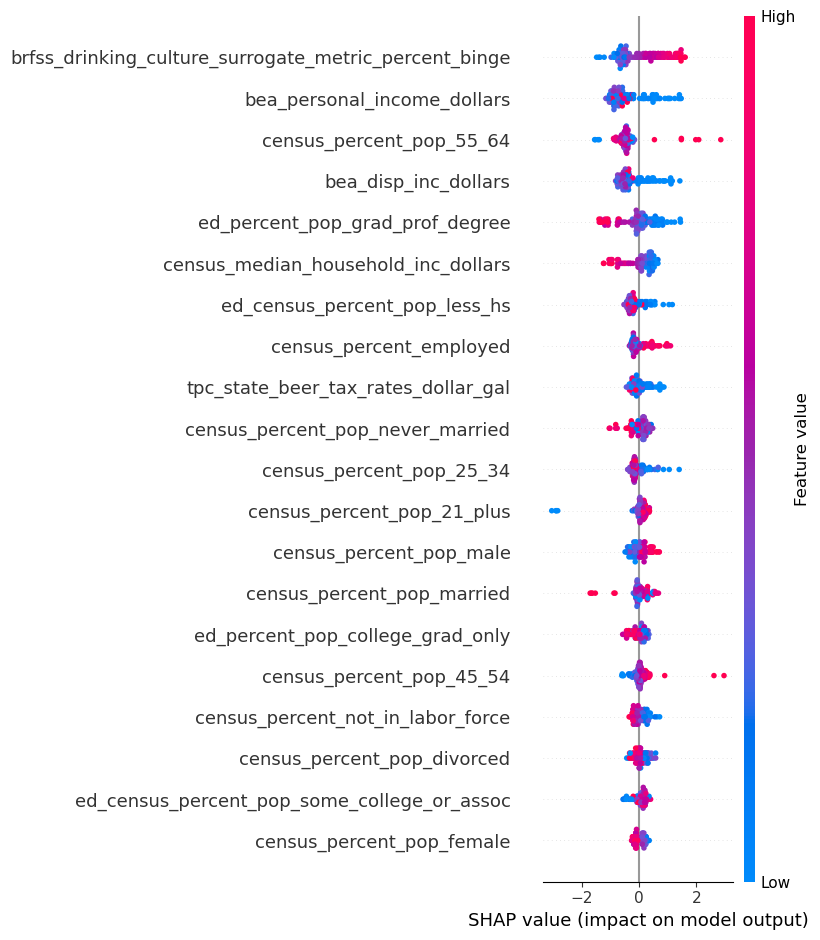

In [10]:
# Convert the transformed data back to DataFrames to retain feature names
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)

# Initialize the SHAP Explainer with the model using the DataFrame (which includes feature names)
explainer = shap.Explainer(best_pipeline.named_steps['regressor'], X_train_transformed_df)

# Calculate SHAP values for the test set transformed DataFrame
shap_values = explainer(X_test_transformed_df)

# Summary plot with correct feature names
shap.summary_plot(shap_values, X_test_transformed_df, feature_names=transformed_feature_names)